# Read Data Sample

In [2]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",1000)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.std()

0.99589320646770185

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20','time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)

        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()

            Train.best_acc = 0
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.2)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:1, net.lr:lr})

                        train_batch()
                        count = 10
                        
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(h,f)))
                            train_batch()
                            count -= 1

                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], #net.summary_op
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})

                    test_accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test, 
                                                                                     net.y_: preprocess.y_test, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    
                    test_accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test_, 
                                                                                     net.y_: preprocess.y_test_, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)

                    if epoch % 1 == 0:
                        print("Step {} | Training Loss: {:.6f} | Test Loss: {:.6f} | Test Accuracy: {:.6f}, {:6f}"
                              .format(epoch, train_loss, test_loss, test_accuracy, test_accuracy_))

                    if test_accuracy > Train.best_acc_global:
                        Train.best_acc_global = test_accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if test_accuracy > Train.best_acc:
                        Train.best_acc = test_accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, test_accuracy, test_accuracy_, time.perf_counter() - start_time))})
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, test_accuracy))
            print("Best Accuracy on Test data: {}".format(Train.best_acc))
            

In [ ]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        
        features_arr = [1, 8, 32, 122]
        hidden_layers_arr = [1, 3, 5]

        Train.predictions = {}
        Train.results = []

        epochs = [15]
        lrs = [1e-2, 1e-2]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)

        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/tf_vae_dense_trained_together_nsl_kdd.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd.pkl")

        past_scores.append(temp).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd.pkl")


In [ ]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:15 hidden layers:1 features count:1
Step 1 | Training Loss: 0.000298 | Test Loss: 0.001185 | Test Accuracy: 0.768852, 0.595781
Step 2 | Training Loss: 0.000625 | Test Loss: 0.005653 | Test Accuracy: 0.608410, 0.337046
Step 3 | Training Loss: 0.000527 | Test Loss: 0.064379 | Test Accuracy: 0.768054, 0.575612
Step 4 | Training Loss: 0.000200 | Test Loss: 0.028777 | Test Accuracy: 0.795866, 0.620000
Step 5 | Training Loss: 0.000260 | Test Loss: 0.020053 | Test Accuracy: 0.779853, 0.585992
Step 6 | Training Loss: 0.001094 | Test Loss: 28878365040280862720.000000 | Test Accuracy: 0.758738, 0.552068
Step 7 | High Training Loss: 4940540600446353408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_1/model-4
Step 7 | Training Loss: 0.000257 | Test Loss: 0.017711 | Test Accuracy: 0.772756, 0.579662
Step 8 | Training Loss: 0.000914 | Test Loss: 0.015286 | Test Accuracy:

Step 3 | High Training Loss: 14326514490518875930624.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-2
Step 3 | High Training Loss: 14326514490518875930624.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-2
Step 3 | High Training Loss: 14326514490518875930624.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-2
Step 3 | Training Loss: 0.000029 | Test Loss: 0.003557 | Test Accuracy: 0.781804, 0.588270
Step 4 | Training Loss: 0.000243 | Test Loss: 0.002555 | Test Accuracy: 0.765037, 0.552827
Step 5 | Training Loss: 0.000816 | Test Loss: 0.009924 | Test Accuracy: 0.752839, 0.532068
Step 6 | Training Loss: 0.000858 | Test Loss: 0.010972 | Test Accuracy: 0.750044, 0.528692
Step 7 | Traini

Step 5 | High Training Loss: 35279106048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Training Loss: 35279106048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Training Loss: 35279110144.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Training Loss: 35279106048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Training Loss: 35279110144.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Traini

Step 7 | High Training Loss: 45825036288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 7 | High Training Loss: 45825036288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 7 | High Training Loss: 45825032192.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 7 | High Training Loss: 45825032192.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 7 | High Training Loss: 45825032192.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 7 | High Traini

Step 9 | High Training Loss: 80970728.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 9 | High Training Loss: 80970680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 9 | High Training Loss: 80970696.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 9 | High Training Loss: 80970704.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 9 | High Training Loss: 80970816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 9 | High Training Loss: 809706

Step 15 | Training Loss: 0.000031 | Test Loss: 7699.926758 | Test Accuracy: 0.782869, 0.591899
Step 1 | Training Loss: 0.003023 | Test Loss: 0.000561 | Test Accuracy: 0.637686, 0.485401
Step 2 | High Training Loss: 44760.722656 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 2 | Training Loss: 0.001524 | Test Loss: 0.003780 | Test Accuracy: 0.712074, 0.618397
Step 3 | High Training Loss: 697062464.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 3 | High Training Loss: 8382848000.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 3 | Training Loss: 0.000309 | Test Loss: 25785.685547 | Test Accuracy: 0.738378, 0.668523
Step 4 | High Training Loss: 97207840191545344.00

Step 15 | High Training Loss: 545773.875000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 15 | High Training Loss: 545766.625000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 15 | High Training Loss: 545773.687500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 15 | Training Loss: 0.001026 | Test Loss: 0.007028 | Test Accuracy: 0.619012, 0.445907
Best Accuracy on Test data: 0.8570795059204102
Current Layer Attributes - epochs:15 hidden layers:1 features count:122
Step 1 | Training Loss: nan | Test Loss: nan | Test Accuracy: 0.430758, 0.181603
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_n

Step 3 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters fr

Step 4 | High Training Loss: 171038.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 171039.328125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 632849.562500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 68284408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 68284176.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 6828408

Step 5 | High Training Loss: 246011884732416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 15096659968.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | Training Loss: 0.002024 | Test Loss: 0.027810 | Test Accuracy: 0.803895, 0.631899
Step 6 | High Training Loss: 1609657397834416128.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | High Training Loss: 10354195.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dens

Step 8 | High Training Loss: 22277662720.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 8 | High Training Loss: 22277650432.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 8 | High Training Loss: 22277650432.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 8 | High Training Loss: 22277650432.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 8 | High Training Loss: 4748642816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 8 | Trainin

Step 12 | High Training Loss: 246011884732416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 12 | High Training Loss: 246011884732416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 12 | High Training Loss: 32751.457031 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 12 | High Training Loss: 29981519872.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 12 | High Training Loss: 12824777714565120.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
St

Step 14 | High Training Loss: 246011884732416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 14 | High Training Loss: 246011884732416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 14 | High Training Loss: 246011884732416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 14 | High Training Loss: 246011884732416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 14 | High Training Loss: 1360773644288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/

Step 5 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 450005335877353472.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 246011884732416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 246011884732416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 2

Step 7 | High Training Loss: 326371477815296.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: 326371477815296.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | Training Loss: 0.001412 | Test Loss: 29089146601472.000000 | Test Accuracy: 0.798749, 0.624557
Step 8 | High Training Loss: 443184320.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 8 | High Training Loss: 122902274048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 8 | High Training Loss: 6401895.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters fr

Step 11 | High Training Loss: 2076679077888.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 2076679208960.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 2076679077888.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | Training Loss: 0.000603 | Test Loss: 118939024.000000 | Test Accuracy: 0.860717, 0.744726
Step 12 | High Training Loss: 93994.195312 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 324693981375237119841140736.000000 ... Restoring Net
INFO:tensorflow:Restoring

Step 14 | High Training Loss: 32200282.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 8800119.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 44651773952.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 2072558698496.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 2072558698496.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | Hig

Step 2 | Training Loss: 0.000101 | Test Loss: 0.000529 | Test Accuracy: 0.815782, 0.665570
Step 3 | Training Loss: 0.000080 | Test Loss: 0.000275 | Test Accuracy: 0.841155, 0.711646
Step 4 | Training Loss: 0.000088 | Test Loss: 0.005585 | Test Accuracy: 0.735096, 0.538228
Step 5 | Training Loss: 0.000056 | Test Loss: 0.000274 | Test Accuracy: 0.756920, 0.581772
Step 6 | Training Loss: 0.000016 | Test Loss: 0.000180 | Test Accuracy: 0.850736, 0.749114
Step 7 | Training Loss: 0.000117 | Test Loss: nan | Test Accuracy: 0.845014, 0.723460
Step 8 | Training Loss: 0.000011 | Test Loss: 0.005056 | Test Accuracy: 0.846611, 0.723629
Step 9 | Training Loss: 0.000006 | Test Loss: 0.005283 | Test Accuracy: 0.856858, 0.748776
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-9
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from da

Step 13 | Training Loss: 0.000026 | Test Loss: 0.000336 | Test Accuracy: 0.852777, 0.740591
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-9
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-9
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-9
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-9
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-9
Ste

Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-14
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-14
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-14
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-14
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-14
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from da

Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-6
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-6
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-6
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-6
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-6
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from d

Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-6
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-6
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-6
Step 15 | Training Loss: 0.000005 | Test Loss: 0.000458 | Test Accuracy: 0.857922, 0.751730
Best Accuracy on Test data: 0.8650638461112976
Current Layer Attributes - epochs:15 hidden layers:3 features count:32
Step 1 | Training Loss: 0.000640 | Test Loss: 0.139180 | Test Accuracy: 0.776082, 0.646160
Step 2 | High Training Loss: 289431.125000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden 

Step 1 | Training Loss: 0.000014 | Test Loss: 0.000363 | Test Accuracy: 0.705997, 0.555274
Step 2 | Training Loss: 0.000004 | Test Loss: 0.000396 | Test Accuracy: 0.720103, 0.593671
Step 3 | Training Loss: 0.000015 | Test Loss: 0.000383 | Test Accuracy: 0.768985, 0.641435
Step 4 | Training Loss: 0.000125 | Test Loss: 0.000361 | Test Accuracy: 0.728620, 0.601097
Step 5 | Training Loss: 0.000003 | Test Loss: 0.000376 | Test Accuracy: 0.745298, 0.617131
Step 6 | Training Loss: 0.000040 | Test Loss: 0.000322 | Test Accuracy: 0.745564, 0.600844
Step 7 | Training Loss: 0.000020 | Test Loss: 0.000136 | Test Accuracy: 0.746540, 0.623629
Step 8 | Training Loss: 0.000081 | Test Loss: 0.000313 | Test Accuracy: 0.730616, 0.611392
Step 9 | Training Loss: 0.000018 | Test Loss: 0.000215 | Test Accuracy: 0.762598, 0.652996
Step 10 | Training Loss: 0.000035 | Test Loss: 0.000352 | Test Accuracy: 0.709901, 0.567342
Step 11 | Training Loss: 0.000060 | Test Loss: 0.000515 | Test Accuracy: 0.715845, 0.5540

Step 12 | Training Loss: 0.000026 | Test Loss: 0.000143 | Test Accuracy: 0.864177, 0.760253
Step 13 | Training Loss: 0.000063 | Test Loss: 0.000153 | Test Accuracy: 0.837296, 0.735106
Step 14 | Training Loss: 0.000005 | Test Loss: 0.000144 | Test Accuracy: 0.844659, 0.749789
Step 15 | Training Loss: 0.000022 | Test Loss: 0.000200 | Test Accuracy: 0.833393, 0.723797
Step 1 | Training Loss: 0.001148 | Test Loss: 0.016708 | Test Accuracy: 0.494145, 0.458228
Step 2 | High Training Loss: 45679351169024.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_122/model-11
Step 2 | Training Loss: 0.000029 | Test Loss: 0.000153 | Test Accuracy: 0.833880, 0.728945
Step 3 | Training Loss: 0.000091 | Test Loss: 0.000039 | Test Accuracy: 0.860451, 0.792911
Step 4 | Training Loss: 0.000004 | Test Loss: 0.000146 | Test Accuracy: 0.841421, 0.755696
Step 5 | Training Loss: 0.000032 | Test Loss: 0.000127 | Test Accur

Step 4 | Training Loss: 0.000627 | Test Loss: 0.019749 | Test Accuracy: 0.824610, 0.670127
Step 5 | High Training Loss: 1273810746496516096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-4
Step 5 | High Training Loss: 4882776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-4
Step 5 | Training Loss: 0.000070 | Test Loss: 0.805339 | Test Accuracy: 0.848164, 0.714599
Step 6 | Training Loss: 0.000257 | Test Loss: 0.006778 | Test Accuracy: 0.741040, 0.549873
Step 7 | Training Loss: 0.000207 | Test Loss: 0.016858 | Test Accuracy: 0.779542, 0.580759
Step 8 | High Training Loss: 43229480.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-5
Step 8 | High Training Loss: 959774.875000 ... Res

Step 11 | Training Loss: 0.000157 | Test Loss: 0.008982 | Test Accuracy: 0.700408, 0.444388
Step 12 | Training Loss: 0.000130 | Test Loss: 0.135880 | Test Accuracy: 0.759537, 0.546329
Step 13 | High Training Loss: 332655962100852584716110397440.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 13 | Training Loss: 0.000652 | Test Loss: 0.006078 | Test Accuracy: 0.513840, 0.254599
Step 14 | High Training Loss: 2237627.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 14 | Training Loss: 0.000546 | Test Loss: 0.001520 | Test Accuracy: 0.763307, 0.551139
Step 15 | High Training Loss: 16263.222656 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 15 | Training Loss: 0.00012

Step 3 | High Training Loss: 37664380694822912.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 37664380694822912.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 37664380694822912.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 37664380694822912.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 37664380694822912.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features cou

Step 5 | High Training Loss: 182481071826448416768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 182481071826448416768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 182481071826448416768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 19062.537109 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 12438379220843888640.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features 

Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: 27735202132379085832192.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: 154884895673828769792.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: 154884895

Step 10 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 40157122134016.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 154884895673828769792.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 154884895673

Step 11 | High Training Loss: 18835.619141 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 11 | Training Loss: 0.005778 | Test Loss: 0.009755 | Test Accuracy: 0.615862, 0.503797
Step 12 | High Training Loss: 3010410491936768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 33950.726562 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 18910.191406 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 18920.986328 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_t

Step 12 | High Training Loss: 19139.949219 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 19150.529297 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 19139.517578 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 19136.099609 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 19159.933594 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 19145

Step 2 | High Training Loss: 236167.890625 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 2 | High Training Loss: 17546.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 2 | High Training Loss: 18673.404297 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 2 | High Training Loss: 18670.630859 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 2 | High Training Loss: 18665.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 2 | High Training Loss: 18679.7460

Step 3 | High Training Loss: 18672.154297 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 3 | High Training Loss: 18665.671875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 3 | High Training Loss: 18685.771484 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 3 | High Training Loss: 18677.462891 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 3 | High Training Loss: 18672.576172 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 3 | High Training Loss: 18667.89648

Step 9 | High Training Loss: 6526923.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 410559447040.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 410559414272.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 410559512576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 410559578112.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High T

Step 12 | High Training Loss: 20096034816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 1983611648.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 27327760384.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 410559414272.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 410559479808.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 |

Step 7 | Training Loss: 0.000031 | Test Loss: 0.000257 | Test Accuracy: 0.773155, 0.579156
Step 8 | Training Loss: 0.000020 | Test Loss: 0.000287 | Test Accuracy: 0.742637, 0.519072
Step 9 | Training Loss: 0.000013 | Test Loss: 0.000302 | Test Accuracy: 0.771469, 0.573418
Step 10 | Training Loss: 0.000011 | Test Loss: 0.000323 | Test Accuracy: 0.767477, 0.568017
Step 11 | Training Loss: 0.000015 | Test Loss: 0.000287 | Test Accuracy: 0.750177, 0.530802
Step 12 | Training Loss: 0.000072 | Test Loss: 0.000307 | Test Accuracy: 0.753327, 0.537300
Step 13 | Training Loss: 0.000029 | Test Loss: 0.000287 | Test Accuracy: 0.741838, 0.516962
Step 14 | Training Loss: 0.000005 | Test Loss: 0.000245 | Test Accuracy: 0.748935, 0.530464
Step 15 | Training Loss: 0.000026 | Test Loss: 0.000293 | Test Accuracy: 0.746984, 0.525485
Best Accuracy on Test data: 0.8933197259902954
Current Layer Attributes - epochs:15 hidden layers:3 features count:32
Step 1 | Training Loss: 0.000024 | Test Loss: 0.000684 | 

Step 5 | Training Loss: 0.000010 | Test Loss: 0.000385 | Test Accuracy: 0.586719, 0.577637
Step 6 | Training Loss: 0.000216 | Test Loss: 0.000281 | Test Accuracy: 0.556867, 0.458650
Step 7 | Training Loss: 0.000083 | Test Loss: 0.000444 | Test Accuracy: 0.568311, 0.469620
Step 8 | Training Loss: 0.000255 | Test Loss: 0.000409 | Test Accuracy: 0.633872, 0.534262
Step 9 | Training Loss: 0.000100 | Test Loss: 0.000595 | Test Accuracy: 0.642521, 0.521857
Step 10 | Training Loss: 0.000087 | Test Loss: 0.000391 | Test Accuracy: 0.600648, 0.412658
Step 11 | Training Loss: 0.000041 | Test Loss: 0.000416 | Test Accuracy: 0.700497, 0.559494
Step 12 | Training Loss: 0.000020 | Test Loss: 0.000364 | Test Accuracy: 0.688298, 0.547595
Step 13 | Training Loss: 0.000115 | Test Loss: 0.000383 | Test Accuracy: 0.689008, 0.554093
Step 14 | Training Loss: 0.000103 | Test Loss: 0.000285 | Test Accuracy: 0.702094, 0.562194
Step 15 | Training Loss: 0.000085 | Test Loss: 0.000384 | Test Accuracy: 0.709812, 0.

Step 13 | Training Loss: 0.000051 | Test Loss: 0.000165 | Test Accuracy: 0.815782, 0.706076
Step 14 | Training Loss: 0.000019 | Test Loss: 0.000185 | Test Accuracy: 0.800878, 0.712996
Step 15 | Training Loss: 0.000085 | Test Loss: 0.000200 | Test Accuracy: 0.811258, 0.687679
Best Accuracy on Test data: 0.85512775182724
Current Layer Attributes - epochs:15 hidden layers:5 features count:122
Step 1 | Training Loss: 0.000171 | Test Loss: 0.000099 | Test Accuracy: 0.853265, 0.742447
Step 2 | Training Loss: 0.000079 | Test Loss: 0.000217 | Test Accuracy: 0.841244, 0.732574
Step 3 | Training Loss: 0.000088 | Test Loss: 0.000229 | Test Accuracy: 0.845990, 0.731899
Step 4 | Training Loss: 0.000017 | Test Loss: 24.658596 | Test Accuracy: 0.634493, 0.517046
Step 5 | High Training Loss: 35001110528.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_122/model-1
Step 5 | Training Loss: 0.000067 | Test Loss:

Step 7 | High Training Loss: 55498.867188 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-6
Step 7 | High Training Loss: 55499.207031 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-6
Step 7 | High Training Loss: 55498.906250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-6
Step 7 | High Training Loss: 55498.656250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-6
Step 7 | High Training Loss: 55498.910156 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-6
Step 7 | Training Loss: 0.000060 | Test Loss: 0.003714 

Step 7 | High Training Loss: 47202056.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 7 | High Training Loss: 47201944.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 7 | High Training Loss: 47201956.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 7 | High Training Loss: 47201944.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 7 | Training Loss: 0.000311 | Test Loss: 7537788937306112.000000 | Test Accuracy: 0.666386, 0.527848
Step 8 | Training Loss: 0.000097 | Test Loss: 2042562432.000000 | Test Accuracy: 0.731592, 0.658819
Step 9 | Training Loss

Step 12 | High Training Loss: 45373864.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 12 | High Training Loss: 25952503094837248.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 12 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 12 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 12 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 12 | High Training Loss: inf ... Restoring Net
INFO:

Step 6 | Training Loss: 0.000973 | Test Loss: 169643728.000000 | Test Accuracy: 0.689851, 0.574599
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 7 | Training Loss: 0.017477 | Test Loss: 39798.160156 | Test Accuracy: 0.821993, 0.663713
Step 8 | High Training Loss: 134693622449785729693320740864.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 8 | Training Loss: 0.000072 | Test Loss: 933654620536832.000000 | Test Accuracy: 0.750843, 0.527426
Step 9 | High Training Loss: 37443072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 9 | Training Loss: 0.000809 | Test Loss: 47254444.000000 | Test Accuracy: 0.767832, 0.562279
Step 10 | High

Step 3 | High Training Loss: 395265.062500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 395237.843750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 395222.125000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 395248.937500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 395222.781250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 395254.4687

Step 11 | High Training Loss: 18892350.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 11 | High Training Loss: 34852916.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 11 | Training Loss: 0.002998 | Test Loss: 0.015574 | Test Accuracy: 0.745520, 0.520506
Step 12 | Training Loss: 0.001161 | Test Loss: 0.004993 | Test Accuracy: 0.778877, 0.583038
Step 13 | High Training Loss: 460877.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 13 | High Training Loss: 35622.363281 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 13 | High Training Loss: 17750404.00

Step 12 | Training Loss: 0.000019 | Test Loss: 0.000333 | Test Accuracy: 0.690383, 0.512911
Step 13 | Training Loss: 0.000017 | Test Loss: 0.000333 | Test Accuracy: 0.727378, 0.563629
Step 14 | Training Loss: 0.000047 | Test Loss: 0.000331 | Test Accuracy: 0.701207, 0.527511
Step 15 | Training Loss: 0.000117 | Test Loss: 0.000304 | Test Accuracy: 0.752484, 0.597722
Step 1 | Training Loss: 0.000013 | Test Loss: 0.000338 | Test Accuracy: 0.707062, 0.551224
Step 2 | Training Loss: 0.000115 | Test Loss: 0.000369 | Test Accuracy: 0.691803, 0.537553
Step 3 | Training Loss: 0.000007 | Test Loss: 0.000216 | Test Accuracy: 0.740463, 0.595527
Step 4 | High Training Loss: 599691.812500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_1/model-8
Step 4 | Training Loss: 0.000007 | Test Loss: 0.000270 | Test Accuracy: 0.765614, 0.645063
Step 5 | Training Loss: 0.000067 | Test Loss: 0.000255 | Test Accuracy: 0.6843

Step 14 | Training Loss: 0.000002 | Test Loss: 0.000170 | Test Accuracy: 0.820972, 0.722025
Step 15 | Training Loss: 0.000010 | Test Loss: 0.000190 | Test Accuracy: 0.843240, 0.757975
Best Accuracy on Test data: 0.8435947299003601
Current Layer Attributes - epochs:15 hidden layers:3 features count:122
Step 1 | Training Loss: 0.000109 | Test Loss: 0.000381 | Test Accuracy: 0.715179, 0.554599
Step 2 | Training Loss: 0.000181 | Test Loss: 0.001759 | Test Accuracy: 0.726845, 0.508439
Step 3 | Training Loss: 0.000087 | Test Loss: 0.006363 | Test Accuracy: 0.799991, 0.623797
Step 4 | Training Loss: 0.000053 | Test Loss: 0.000250 | Test Accuracy: 0.667362, 0.419916
Step 5 | Training Loss: 0.000099 | Test Loss: 0.000318 | Test Accuracy: 0.725426, 0.496456
Step 6 | Training Loss: 0.000060 | Test Loss: 0.000394 | Test Accuracy: 0.725736, 0.499241
Step 7 | Training Loss: 0.000041 | Test Loss: 0.000322 | Test Accuracy: 0.721478, 0.494346
Step 8 | Training Loss: 0.000066 | Test Loss: 0.000389 | Tes

Step 10 | Training Loss: 0.000013 | Test Loss: 0.000148 | Test Accuracy: 0.781760, 0.606413
Step 11 | Training Loss: 0.000027 | Test Loss: 0.000174 | Test Accuracy: 0.760823, 0.578903
Step 12 | Training Loss: 0.000027 | Test Loss: 0.000209 | Test Accuracy: 0.757363, 0.587089
Step 13 | Training Loss: 0.000058 | Test Loss: 0.000241 | Test Accuracy: 0.729817, 0.506498
Step 14 | Training Loss: 0.000012 | Test Loss: 0.000265 | Test Accuracy: 0.732567, 0.509114
Step 15 | Training Loss: 0.000005 | Test Loss: 0.000293 | Test Accuracy: 0.721034, 0.487089
Best Accuracy on Test data: 0.807620644569397
Current Layer Attributes - epochs:15 hidden layers:5 features count:32
Step 1 | Training Loss: 0.000073 | Test Loss: 0.001056 | Test Accuracy: 0.778655, 0.641266
Step 2 | Training Loss: 0.000262 | Test Loss: 0.000033 | Test Accuracy: 0.792495, 0.645316
Step 3 | Training Loss: 0.000000 | Test Loss: 0.000218 | Test Accuracy: 0.844482, 0.733840
Step 4 | Training Loss: 0.000075 | Test Loss: 0.000262 | T

Step 6 | Training Loss: 0.000239 | Test Loss: 0.001211 | Test Accuracy: 0.777324, 0.601603
Step 7 | High Training Loss: 865149321216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_1/model-1
Step 7 | Training Loss: 0.000058 | Test Loss: 0.000810 | Test Accuracy: 0.814851, 0.657890
Step 8 | Training Loss: 0.000362 | Test Loss: 0.000759 | Test Accuracy: 0.806556, 0.637300
Step 9 | Training Loss: 0.000165 | Test Loss: 0.000646 | Test Accuracy: 0.817557, 0.659494
Step 10 | Training Loss: 0.000197 | Test Loss: 0.001161 | Test Accuracy: 0.795866, 0.613165
Step 11 | Training Loss: 0.000146 | Test Loss: 0.000997 | Test Accuracy: 0.818178, 0.660591
Step 12 | Training Loss: 0.000023 | Test Loss: 0.001128 | Test Accuracy: 0.835921, 0.695274
Step 13 | Training Loss: 0.000039 | Test Loss: 0.001603 | Test Accuracy: 0.855039, 0.731055
Step 14 | Training Loss: 0.000324 | Test Loss: 0.001895 | Test Accuracy:

Step 10 | High Training Loss: 4629116026506706944.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 10 | High Training Loss: 8421341696.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 10 | Training Loss: 0.000601 | Test Loss: 0.004995 | Test Accuracy: 0.668204, 0.537300
Step 11 | Training Loss: 0.000360 | Test Loss: 0.003230 | Test Accuracy: 0.649929, 0.491308
Step 12 | Training Loss: 0.001566 | Test Loss: 170870387366808256512.000000 | Test Accuracy: 0.647489, 0.462785
Step 13 | High Training Loss: 11210936287232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 13 | High Training Loss: 12848977.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters fr

Step 2 | High Training Loss: 99505164779520.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 99505164779520.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 99505164779520.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 99505164779520.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 99505164779520.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1


Step 3 | High Training Loss: 205508690541734701039616.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 205508690541734701039616.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 205508690541734701039616.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 205508690541734701039616.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 1714244122836992.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/h

INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 1362733440.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 205917257099929752436736.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 205917257099929752436736.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 205917257099929752436736.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 20591725709992

Step 5 | High Training Loss: 73074960121200640.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 73074960121200640.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 73074960121200640.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 73074960121200640.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 73074960121200640.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features cou

Step 5 | High Training Loss: 377255834419200.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 377255834419200.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 513009184.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | High Training Loss: 11984.144531 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 5 | Training Loss: 0.001045 | Test Loss: 93644804042260480.000000 | Test Accuracy: 0.807576, 0.669789
Step 6 | High Training Loss: 2619835.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from d

Step 6 | High Training Loss: 73074960121200640.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | High Training Loss: 30091933384704.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | High Training Loss: 446111449088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | High Training Loss: 446111449088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | High Training Loss: 446111449088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Ste

Step 6 | High Training Loss: 672972.875000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | High Training Loss: 672965.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | High Training Loss: 673092.625000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | High Training Loss: 672973.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 6 | Training Loss: 0.001699 | Test Loss: nan | Test Accuracy: 0.850115, 0.720675
Step 7 | High Training Loss: 3583014108055513804511903744.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_

Step 7 | High Training Loss: 101822056366080.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 49723257292587008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 49723257292587008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 49723257292587008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 49723257292587008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count

Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters fr

Step 7 | High Training Loss: 1829414626566355086737408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 16901491531544788992.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 49465387456135168.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 49465387456135168.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 49465387456135168.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_f

Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters fr

Step 8 | High Training Loss: 242030495280398336.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 1137288510844174336.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: inf ... Restorin

Step 8 | High Training Loss: 642356889337724928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 642356889337724928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 642356889337724928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 642356889337724928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 642356889337724928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_feature

Step 8 | High Training Loss: 1834132606543187673088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 1834132606543187673088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 304478174656962867757056.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | H

Step 8 | High Training Loss: 157054300021268949237760.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 157054300021268949237760.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 157054300021268949237760.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 157054300021268949237760.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 157054300021268949237760.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_n

Step 9 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/t

Step 9 | High Training Loss: 32410.199219 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 32421.828125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 32448.175781 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 32407.095703 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | Training Loss: 0.005284 | Test Loss: 127879378152812808503296.000000 | Test Accuracy: 0.847897, 0.719662
Step 10 | High Training Loss: 125219.695312 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_den

Step 10 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 10 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 10 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 10 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 10 | High Training Loss: 2050248540160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_

Step 11 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hid

Step 12 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hid

Step 12 | High Training Loss: 765092505670191736224680509440.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | Training Loss: 0.187904 | Test Loss: inf | Test Accuracy: 0.848696, 0.720000
Step 13 | High Training Loss: 35428.285156 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | High Training Loss: 2510472164762601704652800.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parame

Step 13 | High Training Loss: 8153162517104308518912.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | High Training Loss: 50536406270869504.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | Training Loss: 0.000150 | Test Loss: 10604672712704.000000 | Test Accuracy: 0.835433, 0.694430
Step 14 | High Training Loss: 22539.021484 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 211263858519949967360.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 211263858519949967360.000000 ... Restoring Net
INFO:

Step 14 | High Training Loss: 12701453097369600.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 215683602518638592.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 32345.160156 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 32354.048828 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 32346.236328 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High 

Step 15 | High Training Loss: 2300651264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 2300651776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 2300649984.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 2300649216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 2300648704.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High 

Step 2 | High Training Loss: 68282.828125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 68283.265625 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 68283.664062 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 68290.429688 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 68280.078125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 68278.593750 ...

Step 2 | High Training Loss: 32343.679688 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 32344.919922 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 32345.212891 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 32349.630859 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 32364.005859 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 2 | High Training Loss: 32343.589844 ...

Step 3 | High Training Loss: 68278.390625 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 3 | High Training Loss: 68277.812500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 3 | High Training Loss: 68278.054688 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 3 | High Training Loss: 15522.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 3 | High Training Loss: 2847388991488.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 3 | High Training Loss: 76357439

Step 4 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 4 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 4 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 4 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 4 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/t

Step 5 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 5 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 5 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 5 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 5 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/t

Step 6 | High Training Loss: 53198.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 6 | High Training Loss: 53201.281250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 6 | High Training Loss: 53203.019531 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 6 | High Training Loss: 53202.398438 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 6 | High Training Loss: 53204.734375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 6 | High Training Loss: 53199.441406 ...

Step 7 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 7 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 7 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 7 | High Training Loss: 18364581967812362240.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 7 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/

Step 7 | High Training Loss: 2305225472.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 7 | Training Loss: 0.005444 | Test Loss: 278796231617070762855235584.000000 | Test Accuracy: 0.814274, 0.704979
Step 8 | High Training Loss: 19718541312.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 8 | High Training Loss: 53205.617188 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 8 | High Training Loss: 53197.726562 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 8 | High Training Loss: 53207.832031 ... Restoring Net
INFO:tensorflow:Restoring parameters from datase

Step 8 | High Training Loss: 32347.355469 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 8 | High Training Loss: 32343.859375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 8 | High Training Loss: 32361.031250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 8 | High Training Loss: 32346.775391 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 8 | High Training Loss: 32353.923828 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 8 | High Training Loss: 32363.041016 ...

Step 9 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden l

Step 10 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 10 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 10 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 10 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 10 | High Training Loss: 4008173980630997813690368.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/t

Step 11 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 747035687396972731213975388160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from data

Step 11 | High Training Loss: 68277.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 68277.789062 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 68284.156250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 68282.671875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 68278.578125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: 68280.0703

Step 12 | High Training Loss: 211263858519949967360.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 211263858519949967360.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 211263858519949967360.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 211263858519949967360.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 432737344.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1

Step 12 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 220033580855277387776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 12 | High Training Loss: 56843.371094 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_fea

Step 13 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | High Training Loss: 225493966705045536768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hid

Step 14 | High Training Loss: 748520852766369303155101925376.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 748520852766369303155101925376.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 748520852766369303155101925376.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 748520852766369303155101925376.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 748520852766369303155101925376.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from data

Step 15 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 763574397072210665638543228928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from data

Step 4 | Training Loss: 0.000065 | Test Loss: 0.000545 | Test Accuracy: 0.550169, 0.464979
Step 5 | Training Loss: 0.000039 | Test Loss: 0.000228 | Test Accuracy: 0.485939, 0.296118
Step 6 | Training Loss: 0.000129 | Test Loss: 0.000210 | Test Accuracy: 0.689053, 0.579831
Step 7 | Training Loss: 0.000100 | Test Loss: 0.000174 | Test Accuracy: 0.618346, 0.527848
Step 8 | Training Loss: 0.000121 | Test Loss: 0.000230 | Test Accuracy: 0.652236, 0.581181
Step 9 | Training Loss: 0.000025 | Test Loss: 0.000403 | Test Accuracy: 0.636533, 0.494262
Step 10 | Training Loss: 0.000005 | Test Loss: 0.000358 | Test Accuracy: 0.618391, 0.475105
Step 11 | Training Loss: 0.000117 | Test Loss: 0.000419 | Test Accuracy: 0.627307, 0.472658
Step 12 | Training Loss: 0.000088 | Test Loss: 0.000339 | Test Accuracy: 0.677298, 0.536456
Step 13 | Training Loss: 0.000092 | Test Loss: 0.000335 | Test Accuracy: 0.654720, 0.498734
Step 14 | Training Loss: 0.000125 | Test Loss: 0.000266 | Test Accuracy: 0.722853, 0.6

Step 4 | High Training Loss: 80416816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_32/model-1
Step 4 | High Training Loss: 80417208.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_32/model-1
Step 4 | High Training Loss: 80417248.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_32/model-1
Step 4 | High Training Loss: 80416792.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_32/model-1
Step 4 | High Training Loss: 80416776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_32/model-1
Step 4 | High Training Loss: 804171

Step 13 | Training Loss: 0.000019 | Test Loss: 0.000126 | Test Accuracy: 0.892654, 0.828439
Step 14 | Training Loss: 0.000047 | Test Loss: 0.000191 | Test Accuracy: 0.873093, 0.807679
Step 15 | Training Loss: 0.000004 | Test Loss: 0.000063 | Test Accuracy: 0.883650, 0.828523
Best Accuracy on Test data: 0.8950496912002563
Current Layer Attributes - epochs:15 hidden layers:5 features count:1
Step 1 | Training Loss: 0.000649 | Test Loss: 0.000410 | Test Accuracy: 0.642300, 0.613080
Step 2 | Training Loss: 0.000113 | Test Loss: 0.000392 | Test Accuracy: 0.689984, 0.672405
Step 3 | Training Loss: 0.000473 | Test Loss: 0.000021 | Test Accuracy: 0.651925, 0.617637
Step 4 | Training Loss: 0.000195 | Test Loss: 0.000421 | Test Accuracy: 0.647401, 0.636962
Step 5 | Training Loss: 0.000020 | Test Loss: 0.000252 | Test Accuracy: 0.627484, 0.547342
Step 6 | Training Loss: 0.000182 | Test Loss: 0.000294 | Test Accuracy: 0.659200, 0.597553
Step 7 | Training Loss: 0.000308 | Test Loss: 0.000131 | Test

Step 9 | Training Loss: 0.000015 | Test Loss: 0.000172 | Test Accuracy: 0.823634, 0.710380
Step 10 | Training Loss: 0.000039 | Test Loss: 0.000177 | Test Accuracy: 0.821327, 0.704979
Step 11 | Training Loss: 0.000087 | Test Loss: 0.000172 | Test Accuracy: 0.835034, 0.709198
Step 12 | Training Loss: 0.000030 | Test Loss: 0.000123 | Test Accuracy: 0.825763, 0.709620
Step 13 | Training Loss: 0.000018 | Test Loss: 0.000212 | Test Accuracy: 0.829223, 0.717975
Step 14 | Training Loss: 0.000112 | Test Loss: 0.000235 | Test Accuracy: 0.828513, 0.719916
Step 15 | Training Loss: 0.000259 | Test Loss: 0.000040 | Test Accuracy: 0.686081, 0.529620
Best Accuracy on Test data: 0.8431955575942993
Current Layer Attributes - epochs:15 hidden layers:5 features count:122
Step 1 | Training Loss: 0.000013 | Test Loss: 0.000578 | Test Accuracy: 0.711808, 0.472321
Step 2 | Training Loss: 0.000174 | Test Loss: 0.001002 | Test Accuracy: 0.750932, 0.547342
Step 3 | High Training Loss: 72048145485909712699392.000

Step 4 | High Training Loss: 249016.625000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_122/model-2
Step 4 | Training Loss: 0.000093 | Test Loss: 0.000245 | Test Accuracy: 0.821815, 0.742110
Step 5 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_122/model-4
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_122/model-4
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_122/model-4
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_1

Step 5 | Training Loss: 0.000065 | Test Loss: 0.002865 | Test Accuracy: 0.867149, 0.753165
Step 6 | Training Loss: 0.000265 | Test Loss: 0.003060 | Test Accuracy: 0.750310, 0.530886
Step 7 | Training Loss: 0.000048 | Test Loss: 0.002115 | Test Accuracy: 0.765170, 0.559916
Step 8 | Training Loss: 0.001652 | Test Loss: 0.001289 | Test Accuracy: 0.735362, 0.503122
Step 9 | Training Loss: 0.000089 | Test Loss: 0.001544 | Test Accuracy: 0.738955, 0.508270
Step 10 | Training Loss: 0.000151 | Test Loss: 0.001052 | Test Accuracy: 0.739265, 0.511139
Step 11 | Training Loss: 0.000109 | Test Loss: 0.001762 | Test Accuracy: 0.785309, 0.596456
Step 12 | Training Loss: 0.000502 | Test Loss: 0.001800 | Test Accuracy: 0.781450, 0.589367
Step 13 | Training Loss: 0.000638 | Test Loss: 0.001543 | Test Accuracy: 0.782159, 0.591983
Step 14 | Training Loss: 0.000226 | Test Loss: 0.002038 | Test Accuracy: 0.768054, 0.571730
Step 15 | Training Loss: 0.000048 | Test Loss: 0.001616 | Test Accuracy: 0.805802, 0.

Step 8 | High Training Loss: 739115.625000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 8 | High Training Loss: 19243.126953 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 8 | Training Loss: 0.000059 | Test Loss: 141.222748 | Test Accuracy: 0.565649, 0.368608
Step 9 | High Training Loss: 4272683218961956864.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 9 | Training Loss: 0.001543 | Test Loss: 22805446656.000000 | Test Accuracy: 0.832017, 0.685823
Step 10 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 10 | High Training Loss: inf ... R

Step 3 | High Training Loss: 615055294464.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 3 | High Training Loss: 615055294464.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 3 | High Training Loss: 615055294464.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 3 | High Training Loss: 615055294464.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 3 | High Training Loss: 615055294464.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 3 | High T

Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-9
Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from da

Step 2 | High Training Loss: 539839.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 539831.812500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 539818.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 539872.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 539787.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 539841.0625

Step 5 | High Training Loss: 10128762.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 497503141888.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 64263.753906 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 1068155.625000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 1068137.875000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 10

Step 7 | High Training Loss: 42111.187500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 7 | High Training Loss: 42110.714844 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 7 | High Training Loss: 42116.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 7 | High Training Loss: 29828621271040.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 7 | High Training Loss: 1048682.125000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 7 | High Training Loss: 82579

Step 10 | High Training Loss: 1070245.125000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 10 | Training Loss: 2.324616 | Test Loss: 8272627712.000000 | Test Accuracy: 0.727156, 0.608523
Step 11 | High Training Loss: 2339180.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 11 | High Training Loss: 1068130.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 11 | High Training Loss: 1068150.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 11 | High Training Loss: 1068164.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_den

Step 13 | High Training Loss: 2018599168.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 13 | High Training Loss: 2018599296.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 13 | High Training Loss: 57656324.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 13 | High Training Loss: 9207416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 13 | High Training Loss: 56163.515625 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 13 | High Train

Step 15 | High Training Loss: 2018599040.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 15 | High Training Loss: 2018598912.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 15 | High Training Loss: 2018598912.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 15 | High Training Loss: 665549.437500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 15 | High Training Loss: 16453929825900429312.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step

Step 4 | High Training Loss: 492498752.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 4 | High Training Loss: 50559340.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 4 | Training Loss: 0.000069 | Test Loss: 8879.301758 | Test Accuracy: 0.854462, 0.728945
Step 5 | High Training Loss: 8825872714825728.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 5 | High Training Loss: 656926976.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 5 | High Training Loss: 2018599424.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/t

Step 6 | High Training Loss: 321386250240.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 6 | Training Loss: 0.004084 | Test Loss: 44416895025152.000000 | Test Accuracy: 0.850293, 0.719578
Step 7 | High Training Loss: 313123389773304561664.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 7 | High Training Loss: 16453929825900429312.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 7 | High Training Loss: 16453929825900429312.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 7 | High Training Loss: 16453929825900429312.000000 ... Restoring Net


Step 10 | High Training Loss: 7559790985216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 10 | High Training Loss: 22847.304688 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 10 | Training Loss: 0.000072 | Test Loss: 0.002266 | Test Accuracy: 0.831263, 0.682700
Step 11 | High Training Loss: 65351987494912.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 11 | High Training Loss: 275203872559216984064.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 11 | High Training Loss: 1289241472.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from

Step 14 | High Training Loss: 1826645055503335424.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 14 | Training Loss: 0.002369 | Test Loss: 0.535795 | Test Accuracy: 0.632940, 0.490127
Step 15 | High Training Loss: 1476334.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 15 | High Training Loss: 1509485.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 15 | High Training Loss: 133657096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 15 | High Training Loss: 19458.599609 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_

Step 10 | Training Loss: 0.000021 | Test Loss: 0.000273 | Test Accuracy: 0.862491, 0.752911
Step 11 | Training Loss: 0.000012 | Test Loss: 0.000218 | Test Accuracy: 0.864842, 0.756203
Step 12 | Training Loss: 0.000043 | Test Loss: 0.000191 | Test Accuracy: 0.866439, 0.760591
Step 13 | Training Loss: 0.000081 | Test Loss: 0.000281 | Test Accuracy: 0.869988, 0.768861
Step 14 | Training Loss: 0.000032 | Test Loss: 0.000195 | Test Accuracy: 0.882008, 0.785823
Step 15 | Training Loss: 0.000005 | Test Loss: 0.000220 | Test Accuracy: 0.874202, 0.770970
Step 1 | Training Loss: 0.000037 | Test Loss: 0.000215 | Test Accuracy: 0.877174, 0.776203
Step 2 | Training Loss: 0.000031 | Test Loss: 0.000149 | Test Accuracy: 0.893719, 0.810042
Step 3 | Training Loss: 0.000039 | Test Loss: 0.000203 | Test Accuracy: 0.893098, 0.808186
Step 4 | Training Loss: 0.000029 | Test Loss: 0.000125 | Test Accuracy: 0.892787, 0.807679
Step 5 | Training Loss: 0.000036 | Test Loss: 0.000168 | Test Accuracy: 0.895538, 0.

Step 3 | Training Loss: 0.000015 | Test Loss: 0.000355 | Test Accuracy: 0.690117, 0.549367
Step 4 | Training Loss: 0.000070 | Test Loss: 0.000319 | Test Accuracy: 0.701073, 0.580844
Step 5 | Training Loss: 0.000026 | Test Loss: 0.000279 | Test Accuracy: 0.687899, 0.558397
Step 6 | Training Loss: 0.000044 | Test Loss: 0.000327 | Test Accuracy: 0.662793, 0.522700
Step 7 | Training Loss: 0.000090 | Test Loss: 0.000257 | Test Accuracy: 0.677697, 0.547004
Step 8 | Training Loss: 0.000002 | Test Loss: 0.000356 | Test Accuracy: 0.671531, 0.535612
Step 9 | Training Loss: 0.000018 | Test Loss: 0.000297 | Test Accuracy: 0.673394, 0.551561
Step 10 | Training Loss: 0.000095 | Test Loss: 0.000426 | Test Accuracy: 0.669136, 0.530295
Step 11 | Training Loss: 0.000176 | Test Loss: 0.000326 | Test Accuracy: 0.660043, 0.520675
Step 12 | Training Loss: 0.000088 | Test Loss: 0.000321 | Test Accuracy: 0.649574, 0.509789
Step 13 | Training Loss: 0.000037 | Test Loss: 0.000249 | Test Accuracy: 0.706042, 0.59

Step 6 | High Training Loss: 163789242368.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_122/model-3
Step 6 | Training Loss: 0.000004 | Test Loss: 0.000178 | Test Accuracy: 0.864265, 0.759747
Step 7 | Training Loss: 0.000045 | Test Loss: 0.000118 | Test Accuracy: 0.826606, 0.686414
Step 8 | Training Loss: 0.000025 | Test Loss: 0.000069 | Test Accuracy: 0.844970, 0.754177
Step 9 | Training Loss: 0.000023 | Test Loss: 0.000031 | Test Accuracy: 0.855616, 0.771477
Step 10 | Training Loss: 0.000099 | Test Loss: 0.000057 | Test Accuracy: 0.811524, 0.681181
Step 11 | Training Loss: 0.000038 | Test Loss: 0.000094 | Test Accuracy: 0.846256, 0.750633
Step 12 | Training Loss: 0.000015 | Test Loss: 0.000107 | Test Accuracy: 0.822303, 0.708101
Step 13 | Training Loss: 0.000002 | Test Loss: 0.000113 | Test Accuracy: 0.807754, 0.677468
Step 14 | High Training Loss: 176559472640.000000 ... Restoring Net
IN

Step 14 | Training Loss: 0.000132 | Test Loss: 0.001468 | Test Accuracy: 0.757585, 0.545570
Step 15 | Training Loss: 0.000706 | Test Loss: 0.001661 | Test Accuracy: 0.777413, 0.581097
Step 1 | Training Loss: nan | Test Loss: nan | Test Accuracy: 0.430758, 0.181603
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-2
Step 2 | Training Loss: 0.005264 | Test Loss: 0.002368 | Test Accuracy: 0.770715, 0.574093
Step 3 | Training Loss: 0.000140 | Test Loss: 0.002432 | Test Accuracy: 0.696593, 0.442363
Step 4 | Training Loss: 0.000076 | Test Loss: 0.009341 | Test Accuracy: 0.801854, 0.625570
Step 5 | Training Loss: 0.000320 | Test Loss: 0.040668 | Test Accuracy: 0.800035, 0.620422
Step 6 | High Training Loss: 201279216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-

Step 2 | High Training Loss: 12986.683594 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 53851086848.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 29302128.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 29302102.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 29302100.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 293021

Step 4 | High Training Loss: 15723.828125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 15710.209961 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 15710.013672 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 15712.808594 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 15711.490234 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 15710.083984 ... Rest

Step 8 | High Training Loss: 1188456453779172098048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 8 | High Training Loss: 1188456453779172098048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 8 | High Training Loss: 1188456453779172098048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 8 | High Training Loss: 1188456453779172098048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 8 | High Training Loss: 1188456453779172098048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden 

Step 14 | High Training Loss: 1186098397161778577408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 14 | Training Loss: 0.002901 | Test Loss: 1760.449585 | Test Accuracy: 0.757496, 0.541435
Step 15 | High Training Loss: 728278.437500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 15 | High Training Loss: 1186098397161778577408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 15 | High Training Loss: 1186098397161778577408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 15 | High Training Loss: 1186098397161778577408.000000 ... Restoring Net
INFO:tensor

Step 4 | High Training Loss: 1186098397161778577408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 4 | High Training Loss: 1186098397161778577408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 4 | High Training Loss: 1186098397161778577408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 4 | High Training Loss: 140744320.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-7
Step 4 | Training Loss: 0.000783 | Test Loss: 283527967229853302784.000000 | Test Accuracy: 0.793471, 0.611899
Step 5 | High Training Loss: 501087824392607506628608.000000 ... Restoring

Step 8 | High Training Loss: 6509831664174112964608.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-4
Step 8 | High Training Loss: 6509831664174112964608.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-4
Step 8 | High Training Loss: 6509831664174112964608.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-4
Step 8 | High Training Loss: 6509831664174112964608.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-4
Step 8 | High Training Loss: 6509831664174112964608.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden 

Step 11 | Training Loss: 0.000007 | Test Loss: 14159820505711198076928.000000 | Test Accuracy: 0.702537, 0.440928
Step 12 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-4
Step 12 | High Training Loss: 6522773883603268927488.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-4
Step 12 | High Training Loss: 6522773883603268927488.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-4
Step 12 | High Training Loss: 6522773883603268927488.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-4
Step 12 | High Training Loss: 6522773883603268927488.000000 ... Restoring Net
IN

Step 2 | High Training Loss: 211855.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | Training Loss: 0.000520 | Test Loss: 26.208622 | Test Accuracy: 0.671132, 0.631899
Step 3 | High Training Loss: 865041711104.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | Training Loss: 0.001583 | Test Loss: 1342.840088 | Test Accuracy: 0.684839, 0.660760
Step 4 | High Training Loss: 1568903.875000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 4 | Training Loss: 0.001092 | Test Loss: 0.006033 | Test Accuracy: 0.848164, 0.729705
Step 5 | High Training Loss: 2050022.875000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_togethe

Step 7 | High Training Loss: 5631449.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 7 | High Training Loss: 5631215.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 7 | High Training Loss: 5631752.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 7 | High Training Loss: 5631623.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 7 | High Training Loss: 5631194.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 7 | High Training Loss: 56631.

Step 11 | High Training Loss: 5631605.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 11 | High Training Loss: 5631345.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 11 | High Training Loss: 5631468.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 11 | High Training Loss: 5631264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 11 | High Training Loss: 5631202.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-4
Step 11 | High Training Loss: 

Step 13 | High Training Loss: 60697.371094 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 251562653720514052048965074944.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 76867464.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 4345011.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 9908438.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Ste

Step 15 | High Training Loss: 6479847.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 15 | High Training Loss: 6479800.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 15 | High Training Loss: 6479801.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 15 | High Training Loss: 6479752.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 15 | High Training Loss: 6479605.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 15 | Training Loss: 

Step 3 | High Training Loss: 148952.546875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 3 | High Training Loss: 148971.781250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 3 | High Training Loss: 148976.625000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 3 | High Training Loss: 148998.625000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 3 | High Training Loss: 148957.046875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 3 | High Training Loss: 148957

Step 6 | High Training Loss: 18939.449219 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 18927.630859 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 18926.996094 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 18927.218750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 18927.144531 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 18959.632812 ...

Step 12 | High Training Loss: 2030413442711552.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 12 | High Training Loss: 2030413442711552.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 12 | High Training Loss: 2030413442711552.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 12 | High Training Loss: 133472800251130988933939200.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 12 | High Training Loss: 4558366.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features c

Step 13 | Training Loss: 0.000348 | Test Loss: 0.004514 | Test Accuracy: 0.832727, 0.687595
Step 14 | High Training Loss: 6464677601532576859684864.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 14 | High Training Loss: 479352448288200589312.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 14 | High Training Loss: 2030413442711552.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 14 | High Training Loss: 2030413442711552.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 14 | High Training Loss: 2030413442711552.000000 ... Restoring Net
INFO:tenso

Step 14 | Training Loss: 0.000068 | Test Loss: 0.286950 | Test Accuracy: 0.801322, 0.698819
Step 15 | Training Loss: 0.000110 | Test Loss: 0.000305 | Test Accuracy: 0.781405, 0.610970
Step 1 | Training Loss: 0.000046 | Test Loss: 0.000252 | Test Accuracy: 0.814141, 0.650633
Step 2 | Training Loss: 0.000098 | Test Loss: 0.000343 | Test Accuracy: 0.793204, 0.616624
Step 3 | Training Loss: 0.000003 | Test Loss: 0.000241 | Test Accuracy: 0.785531, 0.599831
Step 4 | Training Loss: 0.000003 | Test Loss: 0.000270 | Test Accuracy: 0.796531, 0.632489
Step 5 | Training Loss: 0.000033 | Test Loss: 0.000404 | Test Accuracy: 0.756698, 0.558734
Step 6 | Training Loss: 0.000022 | Test Loss: 0.000258 | Test Accuracy: 0.811169, 0.651646
Step 7 | Training Loss: 0.000030 | Test Loss: 0.000269 | Test Accuracy: 0.801056, 0.647426
Step 8 | Training Loss: 0.000027 | Test Loss: 0.000248 | Test Accuracy: 0.806467, 0.644219
Step 9 | Training Loss: 0.000032 | Test Loss: 0.000243 | Test Accuracy: 0.812944, 0.6571

Step 7 | Training Loss: 0.000043 | Test Loss: 0.000290 | Test Accuracy: 0.708703, 0.610042
Step 8 | Training Loss: 0.000029 | Test Loss: 0.000269 | Test Accuracy: 0.711054, 0.615949
Step 9 | Training Loss: 0.000017 | Test Loss: 0.000227 | Test Accuracy: 0.832017, 0.696793
Step 10 | Training Loss: 0.000039 | Test Loss: 0.000233 | Test Accuracy: 0.753327, 0.692911
Step 11 | Training Loss: 0.000044 | Test Loss: 0.000204 | Test Accuracy: 0.737358, 0.663797
Step 12 | Training Loss: 0.000054 | Test Loss: 0.000196 | Test Accuracy: 0.840179, 0.706160
Step 13 | Training Loss: 0.000038 | Test Loss: 0.000147 | Test Accuracy: 0.840667, 0.720253
Step 14 | Training Loss: 0.000022 | Test Loss: 0.000213 | Test Accuracy: 0.845768, 0.722700
Step 15 | Training Loss: 0.000029 | Test Loss: 0.000203 | Test Accuracy: 0.840135, 0.706751
Best Accuracy on Test data: 0.8457682728767395
Current Layer Attributes - epochs:15 hidden layers:5 features count:1
Step 1 | Training Loss: 0.000029 | Test Loss: 0.000890 | T

Step 12 | Training Loss: 0.000000 | Test Loss: 0.000351 | Test Accuracy: 0.794668, 0.623376
Step 13 | Training Loss: 0.000019 | Test Loss: 0.000361 | Test Accuracy: 0.769917, 0.603713
Step 14 | Training Loss: 0.000017 | Test Loss: 0.000280 | Test Accuracy: 0.777724, 0.591814
Step 15 | High Training Loss: 4371220992.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_32/model-3
Step 15 | Training Loss: 0.000036 | Test Loss: 0.000151 | Test Accuracy: 0.858499, 0.788186
Step 1 | Training Loss: 0.000092 | Test Loss: 0.000179 | Test Accuracy: 0.875444, 0.800422
Step 2 | Training Loss: 0.000393 | Test Loss: 0.000362 | Test Accuracy: 0.847676, 0.751055
Step 3 | Training Loss: 0.000032 | Test Loss: 0.000238 | Test Accuracy: 0.870653, 0.777215
Step 4 | Training Loss: 0.000060 | Test Loss: 0.000208 | Test Accuracy: 0.838582, 0.719916
Step 5 | Training Loss: 0.000039 | Test Loss: 0.000214 | Test Accuracy: 

Step 2 | Training Loss: 0.000645 | Test Loss: 0.001157 | Test Accuracy: 0.652103, 0.461519
Step 3 | High Training Loss: 364915.531250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-1
Step 3 | High Training Loss: 674857984.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-1
Step 3 | High Training Loss: 674858752.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-1
Step 3 | High Training Loss: 674858304.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-1
Step 3 | High Training Loss: 674858112.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_toget

Step 9 | High Training Loss: 195604720.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-3
Step 9 | High Training Loss: 195604640.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-3
Step 9 | Training Loss: 0.001198 | Test Loss: 0.001166 | Test Accuracy: 0.741040, 0.513671
Step 10 | High Training Loss: 5279811849700507643186415403008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-3
Step 10 | High Training Loss: 22332770.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-3
Step 10 | High Training Loss: 195604784.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset

Step 7 | High Training Loss: 214705360.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-3
Step 7 | High Training Loss: 214705424.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-3
Step 7 | High Training Loss: 214705264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-3
Step 7 | High Training Loss: 214705312.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-3
Step 7 | High Training Loss: 214705232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-3
Step 7 | High Training Loss: 214705

Step 3 | High Training Loss: 10568799232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 3 | High Training Loss: 10568799232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 3 | High Training Loss: 10568799232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 3 | High Training Loss: 10568799232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 3 | Training Loss: 0.000492 | Test Loss: 80091693056.000000 | Test Accuracy: 0.772090, 0.650295
Step 4 | High Training Loss: 35705640189952.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from data

Step 11 | High Training Loss: 1685762816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 11 | Training Loss: 0.000183 | Test Loss: 0.003067 | Test Accuracy: 0.634271, 0.544219
Step 12 | High Training Loss: 10653356116437362540544.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 12 | Training Loss: 0.002812 | Test Loss: 0.259503 | Test Accuracy: 0.733144, 0.686414
Step 13 | High Training Loss: 11069.333984 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 13 | High Training Loss: 93393.328125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 13 | High Training Loss:

Step 5 | High Training Loss: 20040.894531 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Training Loss: 20041.556641 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Training Loss: 20040.605469 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Training Loss: 20045.675781 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Training Loss: 20040.564453 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 5 | High Training Loss: 20040.691406 ... Rest

Step 12 | Training Loss: 0.001464 | Test Loss: 0.001461 | Test Accuracy: 0.610672, 0.500000
Step 13 | High Training Loss: 56104816640.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 13 | Training Loss: 0.000161 | Test Loss: 33600612.000000 | Test Accuracy: 0.805137, 0.709114
Step 14 | High Training Loss: 187008.875000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 14 | High Training Loss: 19117.416016 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 14 | High Training Loss: 19115.730469 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-2
Step 14 | High Training Loss: 19115.62

Step 2 | High Training Loss: 39523476.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 2 | High Training Loss: 39523460.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 2 | High Training Loss: 22840.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 2 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 2 | High Training Loss: 808025.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 2 | Training Loss: 0.003534 | Test Loss: 0

Step 4 | High Training Loss: 12219316253669239816192.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 12219316253669239816192.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 12219316253669239816192.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 12219316253669239816192.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 12219316253669239816192.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kd

Step 6 | High Training Loss: 89944.062500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 406126816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 27364186112.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 27364175872.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 27364231168.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training 

Step 8 | High Training Loss: 321834.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 44198.648438 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 44193.320312 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 44195.246094 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 44213.109375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 44186.800781 ..

Step 10 | High Training Loss: 5210233344.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 10 | High Training Loss: 5210233344.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 10 | High Training Loss: 5210238976.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 10 | High Training Loss: 5210234880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 10 | High Training Loss: 5210233856.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 10 | High 

Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 11 | High Training Loss: 686613397504.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 11 | High Training Loss: 5210237440.000000 ... Restoring Net
INF

Step 12 | High Training Loss: 5210237440.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 12 | High Training Loss: 5210235904.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 12 | High Training Loss: 5210246656.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 12 | High Training Loss: 5210242048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 12 | High Training Loss: 5210243072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 12 | High 

Step 13 | High Training Loss: 89816208.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 13 | High Training Loss: 89816200.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 13 | High Training Loss: 89816800.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 13 | High Training Loss: 89816576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 13 | High Training Loss: 89817096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 13 | Training Loss: 

Step 14 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 14 | Training Loss: 1.458324 | Test Loss: 28058437632.000000 | Test Accuracy: 0.816137, 0.659831
Step 15 | High Training Loss: 58323460.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 15 | High Training Loss: 89637704.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-9
Step 15 | High Training Loss: 89638048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_togethe

Step 2 | High Training Loss: 787156288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 2 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 2 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 2 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 2 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 2 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Resto

Step 3 | High Training Loss: 29879976329216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 3 | High Training Loss: 29879976329216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 3 | High Training Loss: 29879976329216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 3 | High Training Loss: 29879978426368.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 3 | High Training Loss: 29879982620672.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/mode

Step 4 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 4 | High Training Loss: 37559.113281 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 4 | High Training Loss: 40033.953125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 4 | High Training Loss: 40031.593750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 4 | High Training Loss: 40032.171875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 4 | High Training Loss: 40052.480469 ... Res

Step 5 | High Training Loss: 30341943263232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 5 | High Training Loss: 30341941166080.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 5 | High Training Loss: 30341941166080.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 5 | High Training Loss: 30341943263232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 5 | High Training Loss: 30341941166080.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/mode

Step 6 | High Training Loss: 30341941166080.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 6 | High Training Loss: 30341945360384.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 6 | High Training Loss: 30341941166080.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 6 | High Training Loss: 100126.859375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 6 | High Training Loss: 717961225087295473315741696.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122

Step 6 | Training Loss: 0.002118 | Test Loss: 129357422592.000000 | Test Accuracy: 0.856015, 0.731055
Step 7 | High Training Loss: 236420031578112.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 7 | High Training Loss: 29879976329216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 7 | High Training Loss: 29879976329216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 7 | High Training Loss: 29879976329216.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 7 | High Training Loss: 29879978426368.000000 ... Restoring Net
INFO:tensorflow:Restorin

Step 8 | High Training Loss: 40045.695312 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 8 | High Training Loss: 40042.109375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 8 | High Training Loss: 40037.617188 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 8 | High Training Loss: 40036.082031 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 8 | High Training Loss: 40045.675781 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-15
Step 8 | High Training Loss: 40037.27343

Step 9 | High Training Loss: 75124696.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 75124120.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 75124672.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 75125312.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 75124264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 7

Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring paramet

Step 13 | High Training Loss: 35580.863281 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | High Training Loss: 6632019526156288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 13 | Training Loss: 0.005774 | Test Loss: 0.001830 | Test Accuracy: 0.830598, 0.720253
Step 14 | High Training Loss: 2029243.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 74867280.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 74867168.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_den

INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 418377564160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 74866984.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 74866992.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-8
Step 15 | High Training Loss: 74867888.000000 ... Restoring Net
INFO:tensorflow:Restoring paramet

Step 1 | Training Loss: 0.000034 | Test Loss: 0.027748 | Test Accuracy: 0.865463, 0.759662
Step 2 | Training Loss: 0.000027 | Test Loss: 0.000722 | Test Accuracy: 0.761311, 0.588101
Step 3 | Training Loss: 0.000056 | Test Loss: 0.000252 | Test Accuracy: 0.776082, 0.586076
Step 4 | High Training Loss: 9962277574803456.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_32/model-1
Step 4 | Training Loss: 0.000033 | Test Loss: 0.000346 | Test Accuracy: 0.861826, 0.747089
Step 5 | Training Loss: 0.000064 | Test Loss: 0.048853 | Test Accuracy: 0.756787, 0.629705
Step 6 | Training Loss: 0.000105 | Test Loss: 0.000070 | Test Accuracy: 0.849006, 0.737637
Step 7 | Training Loss: 0.000105 | Test Loss: 0.000306 | Test Accuracy: 0.871451, 0.767089
Step 8 | High Training Loss: 1057056.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layer

Step 5 | Training Loss: 0.000044 | Test Loss: 0.000096 | Test Accuracy: 0.558375, 0.480760
Step 6 | Training Loss: 0.000074 | Test Loss: 0.000236 | Test Accuracy: 0.615463, 0.506582
Step 7 | Training Loss: 0.000092 | Test Loss: 0.000478 | Test Accuracy: 0.601224, 0.489451
Step 8 | Training Loss: 0.000019 | Test Loss: 0.000298 | Test Accuracy: 0.671842, 0.554177
Step 9 | Training Loss: 0.000346 | Test Loss: 0.000050 | Test Accuracy: 0.715534, 0.572405
Step 10 | Training Loss: 0.000745 | Test Loss: 0.000973 | Test Accuracy: 0.522046, 0.531477
Step 11 | Training Loss: 0.000170 | Test Loss: 0.000213 | Test Accuracy: 0.622560, 0.438987
Step 12 | Training Loss: 0.000144 | Test Loss: 0.000202 | Test Accuracy: 0.637110, 0.460675
Step 13 | Training Loss: 0.000079 | Test Loss: 0.000225 | Test Accuracy: 0.692867, 0.582785
Step 14 | Training Loss: 0.000077 | Test Loss: 0.000348 | Test Accuracy: 0.720901, 0.597300
Step 15 | Training Loss: 0.000005 | Test Loss: 0.000263 | Test Accuracy: 0.695706, 0.

Step 7 | Training Loss: 0.000056 | Test Loss: 0.000225 | Test Accuracy: 0.819597, 0.670970
Step 8 | Training Loss: 0.000087 | Test Loss: 0.000369 | Test Accuracy: 0.833526, 0.686329
Step 9 | Training Loss: 0.000031 | Test Loss: 0.000231 | Test Accuracy: 0.829977, 0.678734
Step 10 | Training Loss: 0.000006 | Test Loss: 0.000278 | Test Accuracy: 0.845192, 0.706414
Step 11 | Training Loss: 0.000025 | Test Loss: 0.000356 | Test Accuracy: 0.842131, 0.705823
Step 12 | Training Loss: 0.000081 | Test Loss: 0.000234 | Test Accuracy: 0.813565, 0.647004
Step 13 | Training Loss: 0.000005 | Test Loss: 0.000304 | Test Accuracy: 0.808907, 0.641266
Step 14 | Training Loss: 0.000000 | Test Loss: 0.000367 | Test Accuracy: 0.762287, 0.558565
Step 15 | Training Loss: 0.000012 | Test Loss: 0.000333 | Test Accuracy: 0.763219, 0.560506
Step 1 | Training Loss: 0.000029 | Test Loss: 0.000276 | Test Accuracy: 0.770671, 0.570633
Step 2 | Training Loss: 0.000016 | Test Loss: 0.000431 | Test Accuracy: 0.738822, 0.

Step 1 | Training Loss: 0.000131 | Test Loss: 0.001410 | Test Accuracy: 0.783889, 0.592489
Step 2 | Training Loss: 0.000069 | Test Loss: 0.001756 | Test Accuracy: 0.784865, 0.592996
Step 3 | Training Loss: 0.000225 | Test Loss: 0.001216 | Test Accuracy: 0.760380, 0.544895
Step 4 | Training Loss: 0.000121 | Test Loss: 0.001745 | Test Accuracy: 0.744855, 0.517553
Step 5 | Training Loss: 0.000357 | Test Loss: 0.001892 | Test Accuracy: 0.751952, 0.530717
Step 6 | Training Loss: 0.000032 | Test Loss: 0.005617 | Test Accuracy: 0.643320, 0.398650
Step 7 | Training Loss: 0.000137 | Test Loss: 0.003526 | Test Accuracy: 0.803540, 0.633080
Step 8 | Training Loss: 0.005843 | Test Loss: 0.002674 | Test Accuracy: 0.754746, 0.539072
Step 9 | High Training Loss: 14765270237184.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-7
Step 9 | Training Loss: 0.000044 | Test Loss: 0.006810 | Test Accuracy: 0.

Step 5 | High Training Loss: 19850057361309827072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 5 | High Training Loss: 19850057361309827072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 5 | High Training Loss: 19850057361309827072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 5 | High Training Loss: 19850057361309827072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 5 | Training Loss: 0.000022 | Test Loss: 0.001587 | Test Accuracy: 0.616306, 0.454684
Step 6 | Training Loss: 0.001697 | Test Loss: 0.001156 | Test Accuracy: 0.795245, 0.62118

Step 6 | Training Loss: 0.003420 | Test Loss: 0.014823 | Test Accuracy: 0.838627, 0.696540
Step 7 | High Training Loss: 1391247.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 7 | High Training Loss: 982159.812500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 7 | High Training Loss: 982268.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 7 | High Training Loss: 982290.125000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 7 | High Training Loss: 982204.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl

Step 15 | High Training Loss: 982195.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 15 | High Training Loss: 2835707.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-6
Step 15 | Training Loss: 0.002332 | Test Loss: 0.002440 | Test Accuracy: 0.645981, 0.569283
Best Accuracy on Test data: 0.8386266827583313
Current Layer Attributes - epochs:15 hidden layers:1 features count:122
Step 1 | Training Loss: 0.001437 | Test Loss: inf | Test Accuracy: 0.750532, 0.534937
Step 2 | High Training Loss: 588409.687500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 588422.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_tr

Step 3 | High Training Loss: 57835299274719314766301495296.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 237794.328125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 12641.470703 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 173223285533041089314816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features cou

Step 5 | High Training Loss: 180904240.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 5 | High Training Loss: 180904432.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 5 | High Training Loss: 180904576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 5 | High Training Loss: 180903920.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 5 | High Training Loss: 180903952.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 5 | High Training Lo

Step 7 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden l

Step 10 | High Training Loss: 3319427.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 10 | High Training Loss: 180904928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 10 | High Training Loss: 180903952.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 10 | High Training Loss: 180903840.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 10 | High Training Loss: 180904384.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 10 | High Trainin

Step 11 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 11 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 11 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 11 | High Training Loss: 28166.773438 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 11 | High Training Loss: 127498.882812 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122

Step 13 | High Training Loss: 666290560.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 13 | Training Loss: 0.001419 | Test Loss: 566254.000000 | Test Accuracy: 0.824565, 0.672996
Step 14 | High Training Loss: 1092032462848.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 14 | High Training Loss: 13336.139648 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 14 | High Training Loss: 432909919977472.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 14 | High Training Loss: 278784586106697416704.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters

Step 3 | High Training Loss: 180904336.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 180904336.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 180903936.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 66632144104980480.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 278231435000902844416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 

Step 4 | High Training Loss: 55061499261843756908906807296.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 55061499261843756908906807296.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 55061499261843756908906807296.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 55061499261843756908906807296.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 7446270976.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_toge

Step 5 | High Training Loss: 266441.656250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 266473.343750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 266450.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 682091904.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 2690664.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 2690990

Step 6 | High Training Loss: 712246955080922693632.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 5036707.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 154595424696717205831680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 5698285713481726007705600.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 5698285713481726007705600.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden laye

Step 7 | High Training Loss: 1278661.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: 5272895835371915941769117696.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: 295544547070425728634847232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: 295544547070425728634847232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 7 | High Training Loss: 295544547070425728634847232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_k

Step 8 | High Training Loss: 336512.156250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 8 | High Training Loss: 23310115162435623428554752.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 8 | High Training Loss: 5698285713481726007705600.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 8 | High Training Loss: 5698285713481726007705600.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 8 | High Training Loss: 5698285713481726007705600.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden

Step 9 | High Training Loss: 6469340.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Loss: 6469340.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Loss: 6469397.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Loss: 6469542.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Loss: 6470094.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Loss: 646934

INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 6469356.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 6469340.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 6469537.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 6469858.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 265119008.000000 ... Restoring Net
INFO:tensorflow:Restoring pa

Step 11 | High Training Loss: 693529870336.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 693529542656.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 693529411584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 693529411584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 693529411584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10


Step 11 | High Training Loss: 23014880283740266823680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 23014880283740266823680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 23014880283740266823680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 12465653236071796101408096256.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 260542611456.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_ns

Step 12 | High Training Loss: 207318399001598751670272.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 207318399001598751670272.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 207318399001598751670272.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 12 | Training Loss: 0.006597 | Test Loss: 3776539787264.000000 | Test Accuracy: 0.849938, 0.730380
Step 13 | High Training Loss: 9780642951145973612544.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 13 | High Training Loss: 693529411584.000000 

Step 13 | Training Loss: 0.007201 | Test Loss: 0.072634 | Test Accuracy: 0.752440, 0.614515
Step 14 | High Training Loss: 21549237395862503118864384.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 14 | High Training Loss: 13293866324726168279842816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 14 | High Training Loss: 13293866324726168279842816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 14 | High Training Loss: 13293866324726168279842816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 14 | High Training Loss: 1329386632472616827984

Step 15 | High Training Loss: 693529411584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 15 | High Training Loss: 693529411584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 15 | High Training Loss: 693529411584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 15 | High Training Loss: 693529673728.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 15 | High Training Loss: 693529411584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10


Step 3 | Training Loss: 0.000021 | Test Loss: 0.000213 | Test Accuracy: 0.812234, 0.675527
Step 4 | Training Loss: 0.000013 | Test Loss: 0.000212 | Test Accuracy: 0.805935, 0.650802
Step 5 | Training Loss: 0.000048 | Test Loss: 0.000144 | Test Accuracy: 0.827892, 0.694515
Step 6 | Training Loss: 0.000053 | Test Loss: 0.003657 | Test Accuracy: 0.785575, 0.629451
Step 7 | High Training Loss: 912395136.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_3_features count_8/model-14
Step 7 | Training Loss: 0.000115 | Test Loss: 0.000213 | Test Accuracy: 0.831663, 0.690042
Step 8 | Training Loss: 0.000066 | Test Loss: 0.000262 | Test Accuracy: 0.821593, 0.675781
Step 9 | Training Loss: 0.000124 | Test Loss: 0.000294 | Test Accuracy: 0.778211, 0.606329
Step 10 | Training Loss: 0.000020 | Test Loss: 0.000184 | Test Accuracy: 0.759936, 0.617637
Step 11 | Training Loss: 0.000066 | Test Loss: 0.005433 | Test Accuracy: 0.81

Step 10 | Training Loss: 0.000100 | Test Loss: 0.000290 | Test Accuracy: 0.689230, 0.528608
Step 11 | Training Loss: 0.000024 | Test Loss: 0.000361 | Test Accuracy: 0.709324, 0.572067
Step 12 | Training Loss: 0.000090 | Test Loss: 0.000327 | Test Accuracy: 0.678318, 0.503713
Step 13 | Training Loss: 0.000097 | Test Loss: 0.000378 | Test Accuracy: 0.694109, 0.559578
Step 14 | Training Loss: 0.000242 | Test Loss: 0.000628 | Test Accuracy: 0.598164, 0.478481
Step 15 | Training Loss: 0.000069 | Test Loss: 0.000273 | Test Accuracy: 0.675479, 0.503122
Step 1 | Training Loss: 0.000000 | Test Loss: 0.000289 | Test Accuracy: 0.674281, 0.510970
Step 2 | Training Loss: 0.000081 | Test Loss: 0.000206 | Test Accuracy: 0.679161, 0.490042
Step 3 | Training Loss: 0.000145 | Test Loss: 0.000218 | Test Accuracy: 0.674326, 0.519240
Step 4 | Training Loss: 0.000094 | Test Loss: 0.000187 | Test Accuracy: 0.680092, 0.510464
Step 5 | Training Loss: 0.000013 | Test Loss: 0.000380 | Test Accuracy: 0.642832, 0.

Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Step 11 | Training Loss: 0.000069 | Test Loss: nan | Test Accuracy: 0.817335, 0.693080
Step 12 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Step 12 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Step 12 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Ste

Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-10
Step 15 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters f

Step 4 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-15
Step 4 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-15
Step 4 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-15
Step 4 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-15
Step 4 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-15
Step 4 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from da

Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 7 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset

Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 11 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from d

Step 13 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 13 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 13 | Training Loss: 0.000002 | Test Loss: nan | Test Accuracy: 0.818089, 0.688101
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 14 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 14 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_8/model-6
Step 14 

Step 7 | Training Loss: 0.000011 | Test Loss: 0.000196 | Test Accuracy: 0.818488, 0.663376
Step 8 | Training Loss: 0.000024 | Test Loss: 0.000239 | Test Accuracy: 0.785087, 0.600591
Step 9 | Training Loss: 0.000018 | Test Loss: 0.000252 | Test Accuracy: 0.769872, 0.572489
Step 10 | Training Loss: 0.000010 | Test Loss: 0.000146 | Test Accuracy: 0.844526, 0.715612
Step 11 | Training Loss: 0.000050 | Test Loss: 0.000246 | Test Accuracy: 0.768763, 0.569620
Step 12 | Training Loss: 0.000077 | Test Loss: 0.000230 | Test Accuracy: 0.869100, 0.769958
Step 13 | Training Loss: 0.000069 | Test Loss: 0.000210 | Test Accuracy: 0.858321, 0.747342
Step 14 | Training Loss: 0.000028 | Test Loss: 0.000089 | Test Accuracy: 0.858144, 0.746751
Step 15 | Training Loss: 0.000042 | Test Loss: 0.000110 | Test Accuracy: 0.860761, 0.744219
Best Accuracy on Test data: 0.8742902874946594
Current Layer Attributes - epochs:15 hidden layers:5 features count:122
Step 1 | Training Loss: 0.000002 | Test Loss: 0.000200 |

Step 3 | Training Loss: 0.000165 | Test Loss: 0.004590 | Test Accuracy: 0.760912, 0.549114
Step 4 | Training Loss: 0.000050 | Test Loss: 0.004276 | Test Accuracy: 0.723474, 0.480000
Step 5 | High Training Loss: 5438577702240156009269035008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-1
Step 5 | Training Loss: 0.000172 | Test Loss: 0.003653 | Test Accuracy: 0.780119, 0.582110
Step 6 | High Training Loss: 8022740.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-1
Step 6 | Training Loss: 0.000098 | Test Loss: 0.001852 | Test Accuracy: 0.765392, 0.555443
Step 7 | High Training Loss: 21454.277344 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_8/model-1
Step 7 | Training Loss: 0.000819 | Test Loss

Step 6 | High Training Loss: 33945976832.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-5
Step 6 | Training Loss: 0.000807 | Test Loss: 0.002990 | Test Accuracy: 0.548838, 0.312658
Step 7 | Training Loss: 0.000869 | Test Loss: 0.002003 | Test Accuracy: 0.671753, 0.537975
Step 8 | High Training Loss: 315623840.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-5
Step 8 | Training Loss: 0.000076 | Test Loss: 0.000998 | Test Accuracy: 0.708969, 0.490042
Step 9 | High Training Loss: 20905958.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-5
Step 9 | High Training Loss: 47426.363281 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_

Step 2 | High Training Loss: 23014880283740266823680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 2 | High Training Loss: 23014880283740266823680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 2 | High Training Loss: 23014880283740266823680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 2 | High Training Loss: 23014880283740266823680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-10
Step 2 | High Training Loss: 15226676224.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden

Step 3 | High Training Loss: 28617576644771091316736.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 28617576644771091316736.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 28617576644771091316736.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 28617576644771091316736.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 545725.937500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1

Step 9 | High Training Loss: 30297551856992256.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Loss: 4133105.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Loss: 4132569.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Loss: 4132569.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Loss: 4133688.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-5
Step 9 | High Training Lo

Step 15 | Training Loss: 0.000060 | Test Loss: 0.000362 | Test Accuracy: 0.810814, 0.739662
Best Accuracy on Test data: 0.825141966342926
Current Layer Attributes - epochs:15 hidden layers:3 features count:8
Step 1 | Training Loss: 0.000133 | Test Loss: 0.000333 | Test Accuracy: 0.801765, 0.681688
Step 2 | Training Loss: 0.000003 | Test Loss: 0.000191 | Test Accuracy: 0.816004, 0.696287
Step 3 | Training Loss: 0.000082 | Test Loss: 0.000265 | Test Accuracy: 0.807443, 0.669198
Step 4 | Training Loss: 0.000031 | Test Loss: 440546656.000000 | Test Accuracy: 0.781050, 0.602616
Step 5 | Training Loss: 0.000181 | Test Loss: 0.000393 | Test Accuracy: 0.752661, 0.603376
Step 6 | Training Loss: 0.000008 | Test Loss: 0.000162 | Test Accuracy: 0.849938, 0.725232
Step 7 | Training Loss: 0.000020 | Test Loss: 0.000084 | Test Accuracy: 0.868612, 0.784726
Step 8 | Training Loss: 0.000111 | Test Loss: 0.000237 | Test Accuracy: 0.845103, 0.739662
Step 9 | Training Loss: 0.000080 | Test Loss: 0.000166 |

Step 15 | Training Loss: 0.000030 | Test Loss: 0.000126 | Test Accuracy: 0.810637, 0.654599
Best Accuracy on Test data: 0.9120830297470093
Current Layer Attributes - epochs:15 hidden layers:5 features count:122
Step 1 | Training Loss: 0.000251 | Test Loss: 0.000763 | Test Accuracy: 0.681467, 0.567679
Step 2 | Training Loss: 0.000022 | Test Loss: 0.000259 | Test Accuracy: 0.815871, 0.697468
Step 3 | Training Loss: 0.000094 | Test Loss: 0.000078 | Test Accuracy: 0.793382, 0.713165
Step 4 | Training Loss: 0.000138 | Test Loss: 0.000743 | Test Accuracy: 0.854329, 0.761097
Step 5 | Training Loss: 0.000002 | Test Loss: 0.000194 | Test Accuracy: 0.809484, 0.691055
Step 6 | Training Loss: 0.000083 | Test Loss: 0.000137 | Test Accuracy: 0.854107, 0.755612
Step 7 | Training Loss: 0.000079 | Test Loss: 0.000091 | Test Accuracy: 0.909954, 0.855949
Step 8 | High Training Loss: 2953114288128.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_

Step 14 | Training Loss: 0.000464 | Test Loss: 0.000992 | Test Accuracy: 0.720946, 0.489536
Step 15 | Training Loss: 0.000223 | Test Loss: 0.005553 | Test Accuracy: 0.743213, 0.515359
Step 1 | Training Loss: 0.010114 | Test Loss: 0.003019 | Test Accuracy: 0.760557, 0.546667
Step 2 | Training Loss: 0.001130 | Test Loss: 0.004182 | Test Accuracy: 0.698989, 0.595865
Step 3 | Training Loss: 0.000658 | Test Loss: 180715.593750 | Test Accuracy: 0.775727, 0.631392
Step 4 | Training Loss: 0.000335 | Test Loss: 0.005508 | Test Accuracy: 0.770981, 0.569789
Step 5 | Training Loss: 0.000167 | Test Loss: 36.829273 | Test Accuracy: 0.668914, 0.531646
Step 6 | Training Loss: 0.000339 | Test Loss: 0.002038 | Test Accuracy: 0.837784, 0.696034
Step 7 | Training Loss: 0.000434 | Test Loss: 14920382619152406642950144.000000 | Test Accuracy: 0.809661, 0.641181
Step 8 | High Training Loss: 10377219733979136.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_toget

Step 7 | High Training Loss: 347234752.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 7 | High Training Loss: 347235360.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 7 | High Training Loss: 347234208.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 7 | High Training Loss: 347234144.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 7 | Training Loss: 0.000084 | Test Loss: 0.001129 | Test Accuracy: 0.749024, 0.527932
Step 8 | High Training Loss: 2419224320.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_train

Step 4 | High Training Loss: 46450281021440.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 4 | Training Loss: 0.001480 | Test Loss: 0.041607 | Test Accuracy: 0.858233, 0.735190
Step 5 | Training Loss: 0.000281 | Test Loss: 0.008108 | Test Accuracy: 0.843018, 0.707004
Step 6 | Training Loss: 0.000878 | Test Loss: 0.008111 | Test Accuracy: 0.823057, 0.670802
Step 7 | High Training Loss: 1424335306752000.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-2
Step 7 | Training Loss: 0.001224 | Test Loss: 0.024388 | Test Accuracy: 0.855882, 0.730127
Step 8 | Training Loss: 0.000533 | Test Loss: 0.011613 | Test Accuracy: 0.864177, 0.750802
Step 9 | Training Loss: 0.002336 | Test Loss: 0.010743 | Test Accuracy: 0.868258, 0.757300
Step 10 | Training Loss: 0.000514 | Test Loss: 0.020

Step 1 | Training Loss: 0.000101 | Test Loss: 0.000364 | Test Accuracy: 0.805270, 0.646245
Step 2 | Training Loss: 0.000025 | Test Loss: 0.000105 | Test Accuracy: 0.794003, 0.642785
Step 3 | Training Loss: 0.000036 | Test Loss: 0.000303 | Test Accuracy: 0.730527, 0.576624
Step 4 | Training Loss: 0.000118 | Test Loss: 0.000441 | Test Accuracy: 0.744189, 0.558228
Step 5 | Training Loss: 0.000006 | Test Loss: 0.000263 | Test Accuracy: 0.766723, 0.587848
Step 6 | Training Loss: 0.000012 | Test Loss: 0.000289 | Test Accuracy: 0.751508, 0.551983
Step 7 | Training Loss: 0.000003 | Test Loss: 0.000240 | Test Accuracy: 0.760291, 0.557468
Step 8 | Training Loss: 0.000061 | Test Loss: 0.000391 | Test Accuracy: 0.745431, 0.553755
Step 9 | Training Loss: 0.000004 | Test Loss: 0.000297 | Test Accuracy: 0.763707, 0.561941
Step 10 | Training Loss: 0.000033 | Test Loss: 0.000264 | Test Accuracy: 0.761666, 0.561857
Step 11 | Training Loss: 0.000041 | Test Loss: 0.000335 | Test Accuracy: 0.753149, 0.5400

Step 14 | Training Loss: 0.000067 | Test Loss: 0.000150 | Test Accuracy: 0.832284, 0.722869
Step 15 | Training Loss: 0.000048 | Test Loss: 0.000199 | Test Accuracy: 0.837207, 0.739662
Step 1 | Training Loss: 0.000066 | Test Loss: 0.000137 | Test Accuracy: 0.834058, 0.731392
Step 2 | Training Loss: 0.000066 | Test Loss: 0.000067 | Test Accuracy: 0.834235, 0.730464
Step 3 | Training Loss: 0.000043 | Test Loss: 0.000123 | Test Accuracy: 0.832727, 0.730633
Step 4 | Training Loss: 0.000059 | Test Loss: 0.000175 | Test Accuracy: 0.833126, 0.729958
Step 5 | Training Loss: 0.000004 | Test Loss: 0.000133 | Test Accuracy: 0.833481, 0.729451
Step 6 | Training Loss: 0.000016 | Test Loss: 0.000129 | Test Accuracy: 0.835655, 0.729958
Step 7 | Training Loss: 0.000020 | Test Loss: 0.000110 | Test Accuracy: 0.834590, 0.731139
Step 8 | Training Loss: 0.000018 | Test Loss: 0.000131 | Test Accuracy: 0.830243, 0.727342
Step 9 | Training Loss: 0.000005 | Test Loss: 0.000121 | Test Accuracy: 0.838094, 0.7416

Step 6 | Training Loss: 0.000029 | Test Loss: 0.000223 | Test Accuracy: 0.853265, 0.734515
Step 7 | High Training Loss: 15532.892578 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_32/model-4
Step 7 | Training Loss: 0.000390 | Test Loss: 0.000701 | Test Accuracy: 0.858188, 0.753333
Step 8 | High Training Loss: 1748410809760840941568.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_5_features count_32/model-4
Step 8 | Training Loss: 0.000027 | Test Loss: 0.000067 | Test Accuracy: 0.877617, 0.789536
Step 9 | Training Loss: 0.000020 | Test Loss: 0.000154 | Test Accuracy: 0.865641, 0.773502
Step 10 | Training Loss: 0.000054 | Test Loss: 0.000119 | Test Accuracy: 0.861914, 0.760591
Step 11 | Training Loss: 0.000025 | Test Loss: 0.000175 | Test Accuracy: 0.854507, 0.737300
Step 12 | Training Loss: 0.000017 | Test Loss: 0.000209

Step 8 | Training Loss: 0.000401 | Test Loss: 0.001688 | Test Accuracy: 0.799725, 0.625907
Step 9 | Training Loss: 0.000052 | Test Loss: 0.001127 | Test Accuracy: 0.803096, 0.638650
Step 10 | Training Loss: 0.000044 | Test Loss: 0.001331 | Test Accuracy: 0.816847, 0.661772
Step 11 | Training Loss: 0.000159 | Test Loss: 0.001138 | Test Accuracy: 0.787793, 0.607848
Step 12 | Training Loss: 0.000016 | Test Loss: 0.001211 | Test Accuracy: 0.848474, 0.723460
Step 13 | Training Loss: 0.000083 | Test Loss: 0.001207 | Test Accuracy: 0.796709, 0.630970
Step 14 | Training Loss: 0.000135 | Test Loss: 0.001996 | Test Accuracy: 0.736914, 0.505907
Step 15 | Training Loss: 0.000477 | Test Loss: 0.001387 | Test Accuracy: 0.773110, 0.575021
Best Accuracy on Test data: 0.8484740853309631
Current Layer Attributes - epochs:15 hidden layers:1 features count:8
Step 1 | Training Loss: 0.000051 | Test Loss: 0.000985 | Test Accuracy: 0.728132, 0.491308
Step 2 | High Training Loss: 25463.087891 ... Restoring Ne

Step 3 | High Training Loss: 1778045550592.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 3 | High Training Loss: 1030365773824.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 3 | High Training Loss: 1030365773824.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 3 | High Training Loss: 1030365839360.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 3 | High Training Loss: 1030365839360.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_32/model-1
Step 3 | H

Step 13 | Training Loss: 0.000701 | Test Loss: 0.002486 | Test Accuracy: 0.694065, 0.567342
Step 14 | Training Loss: 0.000031 | Test Loss: 0.001084 | Test Accuracy: 0.632674, 0.541013
Step 15 | Training Loss: 0.000192 | Test Loss: 0.000220 | Test Accuracy: 0.642743, 0.549705
Best Accuracy on Test data: 0.8026525974273682
Current Layer Attributes - epochs:15 hidden layers:1 features count:122
Step 1 | Training Loss: 0.001164 | Test Loss: 189823690328768512.000000 | Test Accuracy: 0.855527, 0.734430
Step 2 | Training Loss: 0.000476 | Test Loss: 18438300.000000 | Test Accuracy: 0.843728, 0.718481
Step 3 | High Training Loss: 1993826304.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 1128527.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 3 | H

Step 4 | High Training Loss: 15202158373267776208896.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 15202158373267776208896.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 15202158373267776208896.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 1081931645009393496266637312.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 454396922757644288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kd

Step 5 | High Training Loss: 30285592.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 5 | High Training Loss: 248696407064576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 5 | High Training Loss: 15202158373267776208896.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 5 | High Training Loss: 15202158373267776208896.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-1
Step 5 | High Training Loss: 15202158373267776208896.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_featu

Step 7 | High Training Loss: 70670547234586624.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 146485758791562829102827175936.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 146485758791562829102827175936.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 146485758791562829102827175936.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: 146485758791562829102827175936.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_t

Step 8 | High Training Loss: 31088445440.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 31088437248.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 31088439296.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 31088433152.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 31088437248.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-6
Step 8 | High T

Step 12 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 12 | High Training Loss: 11495556513792.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 12 | High Training Loss: 5663966208.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 12 | High Training Loss: 3301553408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-11
Step 12 | Training Loss: 0.001072 | Test Loss: 48106131805618307072.000000 | Test Accuracy: 0.878149, 0.778565
Step 13 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_va

Step 2 | High Training Loss: 76071627523096576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 2 | High Training Loss: 76071627523096576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 2 | High Training Loss: 76071627523096576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 2 | High Training Loss: 76071627523096576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 2 | High Training Loss: 76071627523096576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features

Step 7 | Training Loss: 0.003976 | Test Loss: 0.029200 | Test Accuracy: 0.873758, 0.769367
Step 8 | High Training Loss: 7295764480.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 8 | High Training Loss: 56388116480.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 8 | High Training Loss: 30816.382812 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 8 | High Training Loss: 4222418855919616.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 8 | Training Loss: 0.000681 | Test Loss: 71788.718750 | Test Accuracy: 0.869810, 0.757975
Step 9 | High Training L

Step 12 | High Training Loss: 76071627523096576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 12 | High Training Loss: 76071627523096576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 12 | High Training Loss: 76071627523096576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 12 | High Training Loss: 39498966490562496890220314624.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_1_features count_122/model-12
Step 12 | Training Loss: 0.003186 | Test Loss: 0.001743 | Test Accuracy: 0.829578, 0.680253
Step 13 | High Training Loss: 781698.125000 ... Restoring Net
INFO:tensorflo

Step 12 | Training Loss: 0.000065 | Test Loss: 0.000663 | Test Accuracy: 0.597321, 0.487342
Step 13 | Training Loss: 0.000275 | Test Loss: 0.000814 | Test Accuracy: 0.527945, 0.384726
Step 14 | Training Loss: 0.000006 | Test Loss: 0.000354 | Test Accuracy: 0.695218, 0.610717
Step 15 | Training Loss: 0.000049 | Test Loss: 0.000660 | Test Accuracy: 0.648421, 0.536287
Step 1 | Training Loss: 0.000039 | Test Loss: 0.000433 | Test Accuracy: 0.700763, 0.558397
Step 2 | Training Loss: 0.000026 | Test Loss: 0.000340 | Test Accuracy: 0.650639, 0.496118
Step 3 | Training Loss: 0.000093 | Test Loss: 0.000164 | Test Accuracy: 0.747117, 0.643544
Step 4 | Training Loss: 0.000008 | Test Loss: 0.000115 | Test Accuracy: 0.779808, 0.663460
Step 5 | Training Loss: 0.000164 | Test Loss: 0.000155 | Test Accuracy: 0.781627, 0.671308
Step 6 | Training Loss: 0.000043 | Test Loss: 0.000337 | Test Accuracy: 0.773066, 0.668354
Step 7 | Training Loss: 0.000116 | Test Loss: 0.000255 | Test Accuracy: 0.699698, 0.57

Step 14 | Training Loss: 0.000061 | Test Loss: 0.000164 | Test Accuracy: 0.895005, 0.825401
Step 15 | Training Loss: 0.000043 | Test Loss: 0.000128 | Test Accuracy: 0.894384, 0.824894
Best Accuracy on Test data: 0.898908793926239
Current Layer Attributes - epochs:15 hidden layers:3 features count:122
Step 1 | Training Loss: 0.000080 | Test Loss: 0.000197 | Test Accuracy: 0.748669, 0.588270
Step 2 | Training Loss: 0.000054 | Test Loss: 0.000275 | Test Accuracy: 0.826428, 0.699747
Step 3 | Training Loss: 0.000200 | Test Loss: 0.000226 | Test Accuracy: 0.805181, 0.649789
Step 4 | Training Loss: 0.000057 | Test Loss: 0.000447 | Test Accuracy: 0.467441, 0.267764
Step 5 | Training Loss: 0.000107 | Test Loss: 0.000333 | Test Accuracy: 0.468018, 0.281181
Step 6 | Training Loss: 0.000105 | Test Loss: 0.000393 | Test Accuracy: 0.480261, 0.313418
Step 7 | Training Loss: 0.000111 | Test Loss: 0.000281 | Test Accuracy: 0.468417, 0.295527
Step 8 | Training Loss: 0.000045 | Test Loss: 0.000434 | Test

Step 8 | Training Loss: 0.000002 | Test Loss: 0.000229 | Test Accuracy: 0.705110, 0.468101
Step 9 | Training Loss: 0.000056 | Test Loss: 0.000287 | Test Accuracy: 0.703158, 0.510464
Step 10 | Training Loss: 0.000068 | Test Loss: 0.000403 | Test Accuracy: 0.698279, 0.460844
Step 11 | Training Loss: 0.000045 | Test Loss: 0.000394 | Test Accuracy: 0.698146, 0.493587
Step 12 | Training Loss: 0.000049 | Test Loss: 0.000364 | Test Accuracy: 0.776659, 0.628186
Step 13 | Training Loss: 0.000019 | Test Loss: 0.000302 | Test Accuracy: 0.780030, 0.612236
Step 14 | Training Loss: 0.000056 | Test Loss: 0.000198 | Test Accuracy: 0.776038, 0.605316
Step 15 | Training Loss: 0.000026 | Test Loss: 0.000236 | Test Accuracy: 0.792716, 0.624135
Best Accuracy on Test data: 0.8547285199165344
Current Layer Attributes - epochs:15 hidden layers:5 features count:32
Step 1 | Training Loss: 0.000074 | Test Loss: 0.000092 | Test Accuracy: 0.693089, 0.589620
Step 2 | Training Loss: 0.000059 | Test Loss: 0.000307 | 

In [ ]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
6,30,32,3,0.870490,0.898909,0.833587,79.247999
11,30,122,5,0.900258,0.888307,0.804388,107.291324
10,30,32,5,0.909387,0.883517,0.789283,97.910843
3,30,122,1,0.917563,0.880234,0.779831,100.474774
9,30,8,5,0.889740,0.854729,0.734093,40.264003
0,30,1,1,0.885255,0.848474,0.723460,44.616677
7,30,122,3,0.932606,0.826428,0.699747,8.569921
1,30,8,1,0.869776,0.823013,0.666667,36.424013
8,30,1,5,0.834253,0.815073,0.704557,144.770145
4,30,1,3,0.751419,0.802874,0.698650,74.924590


In [ ]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9207  0.0793]
 [ 0.0944  0.9056]]


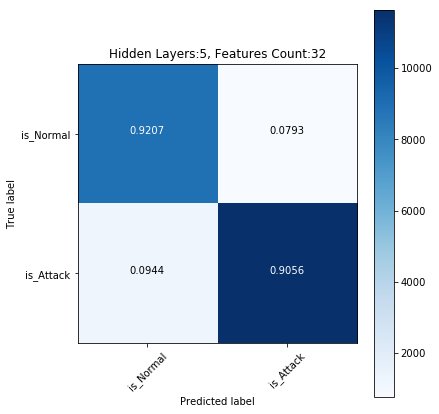

In [ ]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.7551  0.2449]
 [ 0.1237  0.8763]]


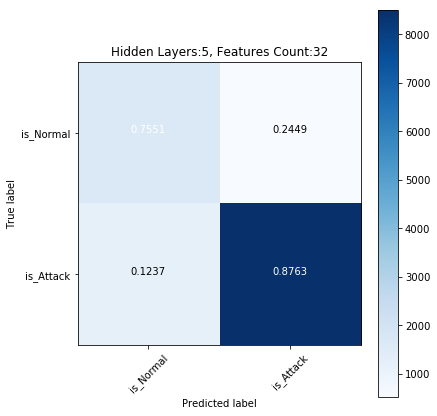

In [ ]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [10]:
past_scores = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd.pkl")

In [11]:
past_scores

,,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,hidden_layers,,,,,
1,1,30,0.862354,0.874379,0.775359,50.792692
8,1,30,0.900179,0.849583,0.720675,66.763818
32,1,30,0.932368,0.857080,0.736287,25.677360
122,1,30,0.912681,0.868479,0.757553,90.556620
1,3,30,0.769359,0.770005,0.700422,57.785871
8,3,30,0.910300,0.865064,0.764641,86.743298
32,3,30,0.895019,0.785619,0.629367,8.044837
122,3,30,0.923874,0.760424,0.567089,4.703354
1,5,30,0.804168,0.768985,0.641435,96.900068


In [12]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.max().sort_values(by="test_score", ascending = False)

,,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,hidden_layers,,,,,
32,5,30,0.949077,0.912083,0.858903,130.327578
122,5,30,0.932447,0.909954,0.855949,149.665853
8,3,30,0.938996,0.900284,0.829958,114.754987
32,3,30,0.937011,0.898909,0.833587,101.680368
122,3,30,0.932606,0.895050,0.824894,138.720457
8,1,30,0.913832,0.886045,0.790464,66.763818
1,1,30,0.906688,0.883694,0.790633,52.830932
122,1,30,0.923199,0.880234,0.805485,111.603432
8,5,30,0.927168,0.878815,0.791983,162.873972


In [13]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.min().sort_values(by="test_score", ascending = False)

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
32             5                 30     0.805954    0.843196       0.720253   
122            1                 30     0.851439    0.812456       0.657300   
8              5                 30     0.776940    0.807621       0.677890   
               1                 30     0.869776    0.803540       0.628945   
32             1                 30     0.852153    0.802431       0.626582   
8              3                 30     0.837468    0.787527       0.626498   
32             3                 30     0.814169    0.785619       0.629367   
122            3                 30     0.846517    0.760424       0.567089   
               5                 30     0.865529    0.760158       0.561013   
1              1                 30     0.835959    0.738999       0.597215   
               5                 30     0.619448    0.648066       0.554515   
               3                 30     0.575035    0.596922       0.638734   

                              time_taken  
no_of_features hidden_layers              
32             5               10.595568  
122            1               43.245541  
8              5               11.099639  
               1                4.075877  
32             1               20.456065  
8              3               37.123987  
32             3                3.579034  
122            3                4.703354  
               5                6.524001  
1              1               13.020334  
               5               29.394587  
               3               29.112470

In [14]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean().sort_values(by="test_score", ascending = False)

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
32             5                 30     0.892327    0.872542       0.783136   
122            5                 30     0.898753    0.866180       0.765014   
8              3                 30     0.904786    0.864373       0.763052   
122            1                 30     0.896163    0.860850       0.745647   
8              5                 30     0.863425    0.849372       0.745738   
               1                 30     0.898363    0.848164       0.717257   
32             3                 30     0.900645    0.842730       0.728453   
1              1                 30     0.876970    0.838815       0.714290   
122            3                 30     0.902272    0.834483       0.707911   
32             1                 30     0.907449    0.832350       0.694184   
1              3                 30     0.761824    0.766150       0.681435   
               5                 30     0.785735    0.765266       0.651491   

                              time_taken  
no_of_features hidden_layers              
32             5               61.878930  
122            5               76.937804  
8              3               74.755544  
122            1               85.512800  
8              5               75.760047  
               1               28.810952  
32             3               45.165928  
1              1               42.555612  
122            3               49.892135  
32             1               40.453819  
1              3               73.368615  
               5              110.433396

In [15]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.std().sort_values(by="test_score", ascending = False)

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
1              3                0.0     0.068627    0.061088       0.028520   
122            3                0.0     0.025515    0.050050       0.093773   
1              5                0.0     0.064387    0.045774       0.055457   
               1                0.0     0.017845    0.043988       0.065958   
32             3                0.0     0.033357    0.042433       0.075705   
122            5                0.0     0.021020    0.041707       0.081925   
8              3                0.0     0.025107    0.034472       0.057874   
               1                0.0     0.011292    0.026571       0.052167   
122            1                0.0     0.023955    0.023220       0.044763   
32             5                0.0     0.045012    0.020703       0.044822   
8              5                0.0     0.050200    0.019572       0.032059   
32             1                0.0     0.025703    0.018183       0.032400   

                              time_taken  
no_of_features hidden_layers              
1              3               25.456933  
122            3               53.130223  
1              5               40.763361  
               1               11.128218  
32             3               37.601172  
122            5               50.696693  
8              3               25.269003  
               1               22.358362  
122            1               18.581084  
32             5               40.604846  
8              5               51.522479  
32             1               19.018809